In [1]:

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from statsmodels.tsa import stattools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import *

from sklearn.datasets import load_digits
from scipy.io import arff

from sklearn.feature_selection import SelectKBest, chi2

In [2]:

# pour l'analyse de WADI, il existe 2 datasets:
# 1 avec 100% non-attack
# 1 avec des attaques et non-attaques

#load dataset
dfL = pd.read_csv('WADI_attackdataLABLE.csv',header=1) #contient NON-ATTACK ET ATTACK

In [3]:
len(dfL)

172803

In [4]:
len(dfL.columns)

131

In [5]:

#on regarde la répartition des attaques et des normaux 
print(pd.Series(dfL['label']).value_counts())

 1    162826
-1      9977
Name: label, dtype: int64


In [6]:
#il n'y a pas beaucoup d'attaques :/

In [7]:
dfL = pd.concat([dfL[dfL.label == 1].sample(frac=0.5),dfL[dfL.label == -1]],axis=0)
#ici, on réduit le nombre de observations normales (-50%) car il y en trop et avec ma machine, c'est impossible d'executer les commandes d'ia


In [8]:
dfL.head()

,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,label
163126,163127.0,10/11/17,18:46.0,176.197,0.529486,11.9261,479.460,0.337771,0.001204,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,61.1115,1.0,0.51,1
39813,39814.0,10/10/17,03:33.0,170.816,0.631472,11.9376,470.693,0.305631,0.001197,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,61.3449,1.0,0.00,1
161955,161956.0,10/11/17,59:15.0,176.321,0.529486,11.9268,477.344,0.331435,0.001136,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,65.2046,1.0,0.45,1
73408,73409.0,10/10/17,23:28.0,173.969,0.499489,11.9581,471.322,0.299084,0.001275,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,60.4424,1.0,0.48,1
104448,104449.0,10/10/17,00:48.0,179.324,0.619474,11.8796,474.229,0.331735,0.001084,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,59.4625,1.0,0.09,1


In [9]:
print('Nombre de colonnes : ',len(dfL.columns))
print('Taille du set :',len(dfL))



Nombre de colonnes :  131
Taille du set : 91390


In [10]:
print(pd.Series(dfL['label']).value_counts())
#répartition Attaque / Non attaque

 1    81413
-1     9977
Name: label, dtype: int64


In [11]:
#c'est mieux, 10% sont des attaques 

In [12]:
#Valeurs NaN

In [13]:
dfL.isnull().sum(axis = 0)

Row                         1
Date                        1
Time                        1
1_AIT_001_PV                1
1_AIT_002_PV                1
                           ..
3_P_004_STATUS              1
LEAK_DIFF_PRESSURE          1
PLANT_START_STOP_LOG        1
TOTAL_CONS_REQUIRED_FLOW    1
label                       0
Length: 131, dtype: int64

In [14]:
dfL.dropna(subset =['Time'], inplace=True)
dfL = dfL.fillna(0)

In [15]:
dfL.isnull().sum(axis = 0).any() #plus de NaN

False

In [16]:
df = pd.read_csv("WADI_14days_new.csv") # contient seulement NON-ATTACK
#df = df[df.Row < 500000]
print(len(df))

#ce dataset est énorme, il faut encore une fois réduire le nombre d'observations

784571


In [17]:
df = df.sample(n=210000)

In [18]:
df.head()

,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,...,3_MV_001_STATUS,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW
178567,178568,9/27/2017,36:07.0,205.139,0.601475,11.4332,517.638,0.260724,0.001154,0,...,1,1,1,1,1,1,1,59.8946,1,0.13
190606,190607,9/27/2017,56:46.0,200.613,0.667469,11.4474,518.884,0.299168,0.001133,0,...,1,1,1,1,1,1,1,62.9249,1,0.60
254143,254144,9/28/2017,35:43.0,190.482,0.601473,11.5158,507.142,0.221647,0.001285,0,...,1,1,1,1,1,1,1,59.9601,1,0.00
691499,955500,10/6/17,24:59.0,166.648,0.589479,11.7896,498.555,0.376446,0.001193,0,...,1,1,1,1,1,1,1,59.6637,1,0.00
251188,251189,9/28/2017,46:28.0,188.565,0.613474,11.5316,488.429,0.234631,1.901530,0,...,1,1,1,1,1,1,1,78.8253,1,2.16


In [19]:
# taille total du set

len(df)+len(dfL)

301389

In [20]:
# on cherche les NaNs dans ce dataset également

In [21]:
id = 0
for v in df.isnull().sum(axis = 0).values: # voici les Nans
    if v != 0:
        print(id, v)
    id+=1

4 5
6 2
50 210000
51 210000
86 210000
87 210000
111 5
115 1


In [22]:
print('Nombre de colonnes : ',len(df.columns))
print('Taille du set :',len(df))


df.columns.values

Nombre de colonnes :  130
Taille du set : 210000


array(['Row', 'Date', 'Time', '1_AIT_001_PV', '1_AIT_002_PV',
       '1_AIT_003_PV', '1_AIT_004_PV', '1_AIT_005_PV', '1_FIT_001_PV',
       '1_LS_001_AL', '1_LS_002_AL', '1_LT_001_PV', '1_MV_001_STATUS',
       '1_MV_002_STATUS', '1_MV_003_STATUS', '1_MV_004_STATUS',
       '1_P_001_STATUS', '1_P_002_STATUS', '1_P_003_STATUS',
       '1_P_004_STATUS', '1_P_005_STATUS', '1_P_006_STATUS',
       '2_DPIT_001_PV', '2_FIC_101_CO', '2_FIC_101_PV', '2_FIC_101_SP',
       '2_FIC_201_CO', '2_FIC_201_PV', '2_FIC_201_SP', '2_FIC_301_CO',
       '2_FIC_301_PV', '2_FIC_301_SP', '2_FIC_401_CO', '2_FIC_401_PV',
       '2_FIC_401_SP', '2_FIC_501_CO', '2_FIC_501_PV', '2_FIC_501_SP',
       '2_FIC_601_CO', '2_FIC_601_PV', '2_FIC_601_SP', '2_FIT_001_PV',
       '2_FIT_002_PV', '2_FIT_003_PV', '2_FQ_101_PV', '2_FQ_201_PV',
       '2_FQ_301_PV', '2_FQ_401_PV', '2_FQ_501_PV', '2_FQ_601_PV',
       '2_LS_001_AL', '2_LS_002_AL', '2_LS_101_AH', '2_LS_101_AL',
       '2_LS_201_AH', '2_LS_201_AL', '2_LS_301_AH',

In [23]:
id = 0
for v in df.isnull().sum(axis = 0).values: # voici les Nans
    if v != 0:
        print(id, v)
    id+=1

4 5
6 2
50 210000
51 210000
86 210000
87 210000
111 5
115 1


In [24]:
df = df.fillna(0) # on pourrait aussi remplacer par une valeur moyenne

In [15]:
#############################################################################################################################

                                        #visualisation
#############################################################################################################################

In [16]:
################################################################################################################
################################################################################################################
###################################  sans scaler   #############################################################
################################################################################################################
################################################################################################################

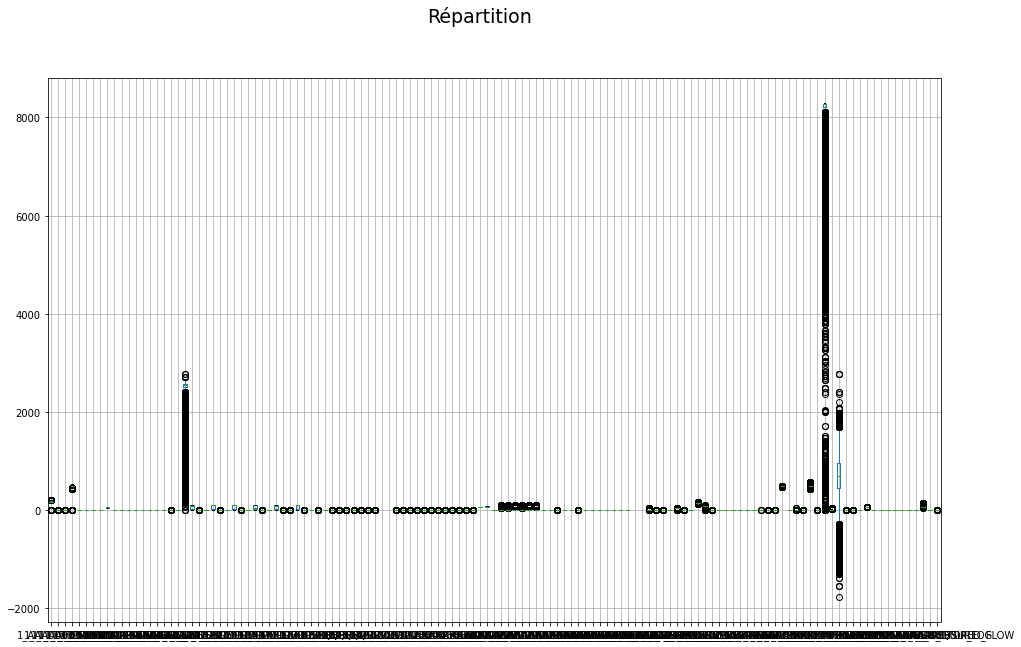

In [23]:
plt.figure(figsize=(16,10))
plt.suptitle('Répartition',fontsize=19)

df.sample(frac=0.7).drop(['Row', 'Date', 'Time'],axis=1).boxplot( )
# des outliers sont présents

In [18]:
#Difficile d'y voir sans scaler

In [19]:
################################################################################################################
################################################################################################################
###################################  avec scaler   #############################################################
################################################################################################################
################################################################################################################

In [25]:
## essaie 1

#on fusionne le dataset qui contient que les attaques et celui avec des attaques

dfL.columns = np.append(df.columns.values,'label')

dtempolabel = pd.DataFrame( data = np.full(len(df),1) , columns = ['label']   )
dtempolabel.reset_index()
df.reset_index()


df = pd.DataFrame( data = df.values , columns = df.columns.values  )

dfF =  pd.concat([ pd.concat([df  , dtempolabel ],axis=1) , dfL ],axis=0)

df=None
dfL=None
##

In [26]:
len(dfF)

301388

In [27]:
id = 0
for v in dfF.isnull().sum(axis = 0).values: # voici les Nans
    if v != 0:
        print(id, v)
    id+=1

In [28]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(output_distribution = "normal")

dfF[dfF.columns.values[3:-1]] = scaler.fit_transform(dfF[dfF.columns.values[3:-1]])


In [12]:
#from sklearn.preprocessing import QuantileTransformer
#scaler = QuantileTransformer(output_distribution = "normal")

#df[df.columns.values[3:]] = scaler.fit_transform(df[df.columns.values[3:]])

#dfL[dfL.columns.values[3:-1]] = scaler.transform(dfL[dfL.columns.values[3:-1]])

#dffullfaulty  = dfL[dfL['label'] == -1] # contient uniquement les attaques

In [13]:
#dfL.columns = np.append(df.columns.values,'label')
#dfF  = pd.concat([df,dfL.drop(['label'],axis=1)])

In [14]:
#len(dfF)

522801

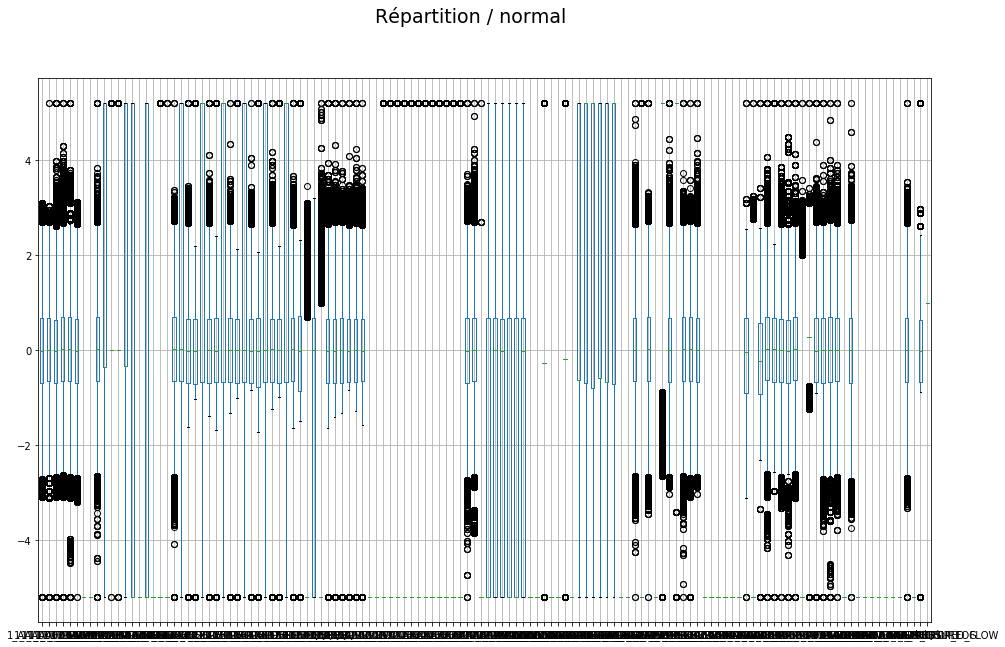

In [21]:
plt.figure(figsize=(16,10))
plt.suptitle('Répartition / normal',fontsize=19)
dfF[dfF.label == 1].drop(['Row', 'Date', 'Time'],axis=1).boxplot( )


In [23]:
#avec le scaler, on visionne mieux la répartition 

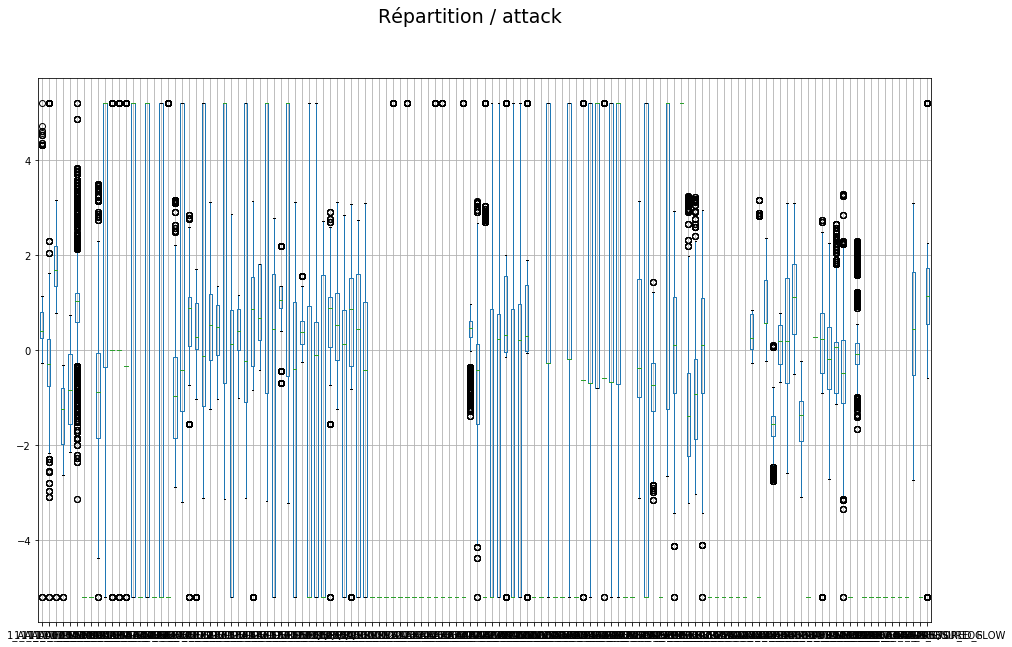

In [23]:
plt.figure(figsize=(16,10))
plt.suptitle('Répartition / attack',fontsize=19)
dfF[dfF.label == -1].drop(['Row', 'Date', 'Time','label'],axis=1).boxplot( )


In [ ]:
# lors des attaques la répartition est plus confuse, c'est un bon signe pour faire de la discrimination

In [ ]:
#étant donné que les valeurs dans le dataset ne sont pas totalement ordonnées(voir publication auteurs), on ne peut pas les visualiser en fonction du temps

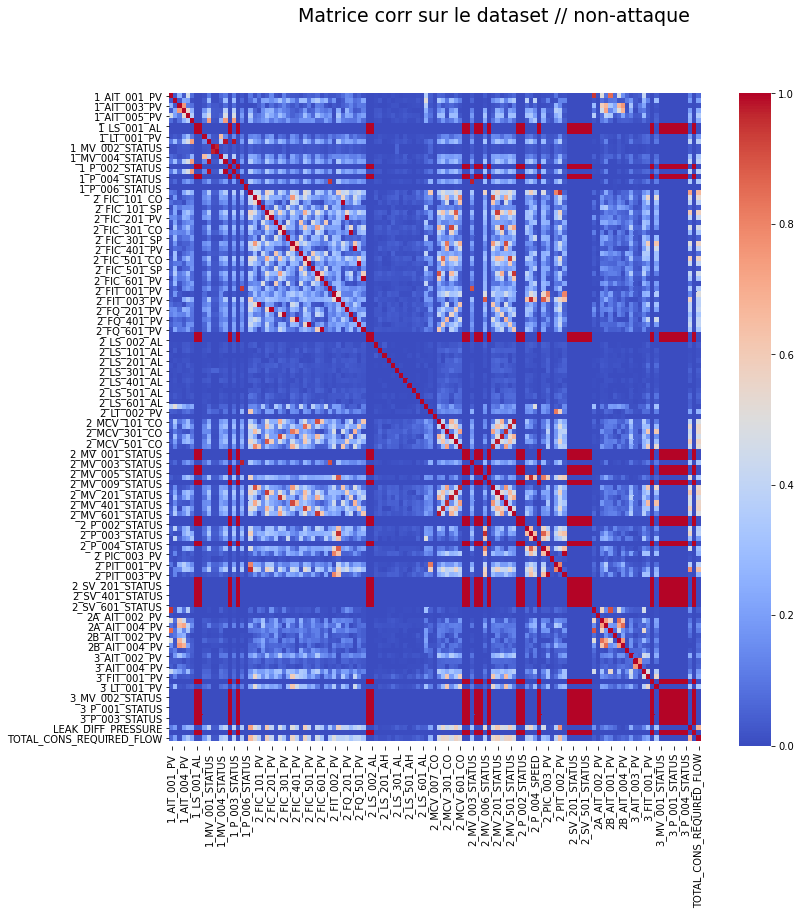

In [30]:

tabcorr=dfF[dfF.label == 1].sample(frac=0.7).drop(['Row', 'Date', 'Time'],axis=1).corr()
plt.figure(figsize=(12,12))
plt.suptitle('Matrice corr sur le dataset // non-attaque',fontsize=19)
sns.heatmap(abs(tabcorr), cmap="coolwarm")

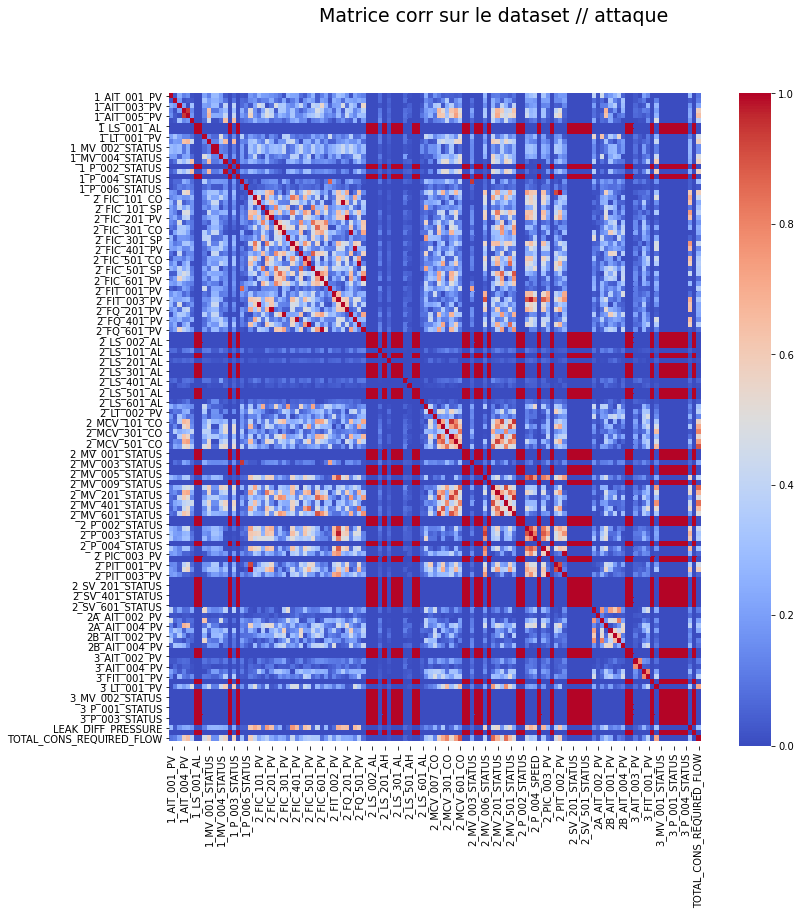

In [31]:

tabcorr=dfF[dfF.label == -1].sample(frac=0.7).drop(['Row', 'Date', 'Time'],axis=1).corr()
plt.figure(figsize=(12,12))
plt.suptitle('Matrice corr sur le dataset // attaque',fontsize=19)
sns.heatmap(abs(tabcorr), cmap="coolwarm")

In [ ]:
#il y a tellement de variables, c'est difficile de voir une différence de correlation
#mais on remarque que c'est plus coloré lors des attaques

Text(0, 0.5, 'Distance ki² entre simulation 1 et 2 ( normales )')

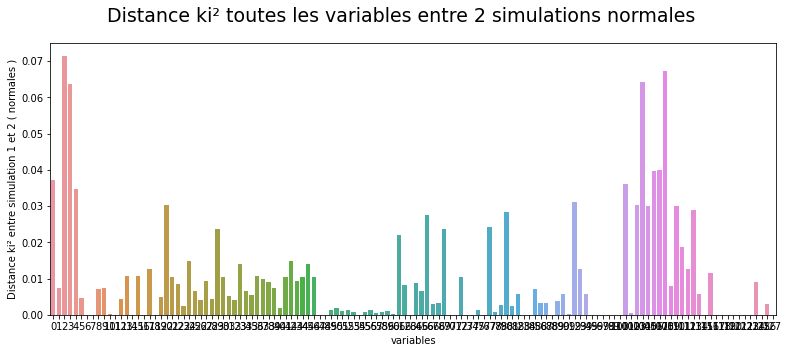

In [32]:
refNonAttaque = dfF[dfF.label == 1].sample(frac=0.7).drop(['Row', 'Date', 'Time'],axis=1)


data_1 = refNonAttaque.sample(frac=0.5)
data_2 = refNonAttaque.drop(data_1.index)

from scipy.stats import energy_distance
distancedistr = []
for sonde in dfF[dfF.label == 1].sample(n=1).drop(['Row', 'Date', 'Time'],axis=1).columns:
    distancedistr.append(energy_distance(data_1[sonde],data_2[sonde]))
plt.figure(figsize=(13,5))
sns.barplot(np.arange(0,len(distancedistr)),distancedistr)
plt.suptitle('Distance ki² toutes les variables entre 2 simulations normales' ,fontsize=19)
plt.xlabel('variables')
plt.ylabel('Distance ki² entre simulation 1 et 2 ( normales )')

Text(0, 0.5, 'Distance ki² entre simulation 1 et 2 ( normales )')

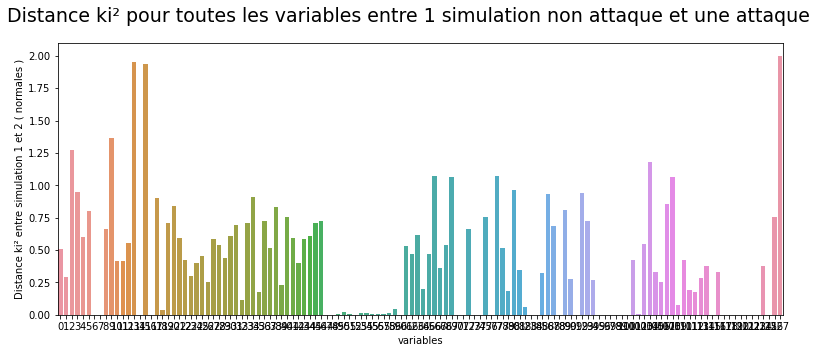

In [33]:
refNonAttaque =dfF[dfF.label == 1].sample(frac=0.7).drop(['Row', 'Date', 'Time'],axis=1)

refAttaque = dfF[dfF.label == -1].sample(frac=0.7).drop(['Row', 'Date', 'Time'],axis=1)


from scipy.stats import energy_distance
distancedistr = []
for sonde in dfF[dfF.label == 1].sample(n=1).drop(['Row', 'Date', 'Time'],axis=1).columns:
    distancedistr.append(energy_distance(refNonAttaque[sonde],refAttaque[sonde]))
plt.figure(figsize=(13,5))
sns.barplot(np.arange(0,len(distancedistr)),distancedistr)
plt.suptitle('Distance ki² pour toutes les variables entre 1 simulation non attaque et une attaque' ,fontsize=19)
plt.xlabel('variables')
plt.ylabel('Distance ki² entre simulation 1 et 2 ( normales )')

In [ ]:
#encore une fois, avec cette analyse statistique, on observe que il y a une différence entre la répartition des données
#lorsqu'il y a une attaque et rien du tout

In [ ]:
#avec plus de 128 variables, c'est compliqué mais on va essayer de regarder les histogrammes 

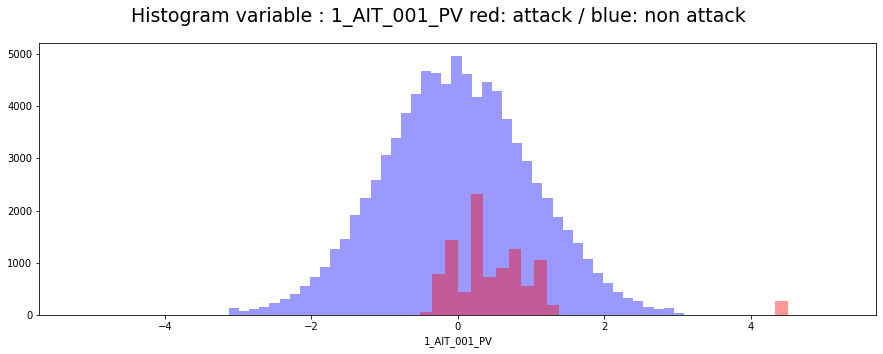

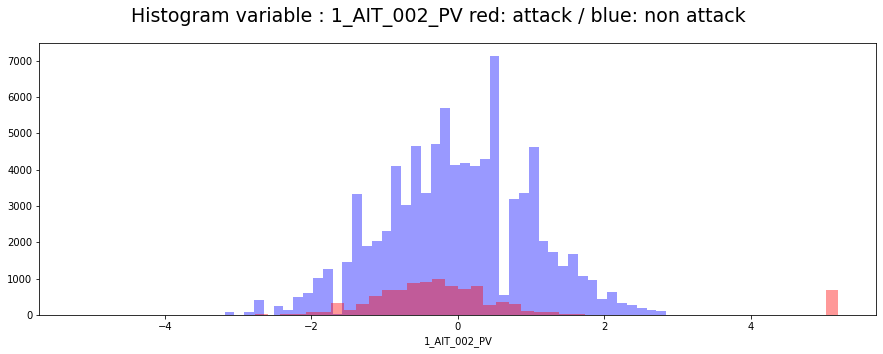

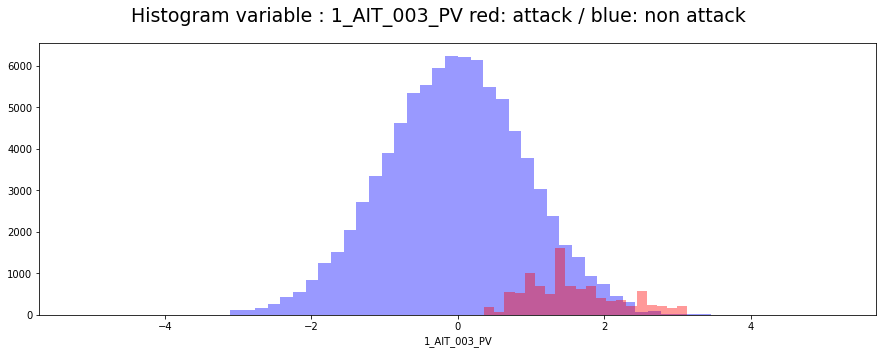

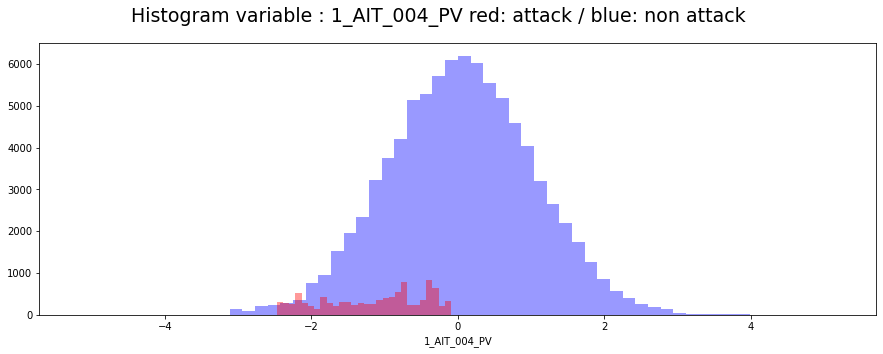

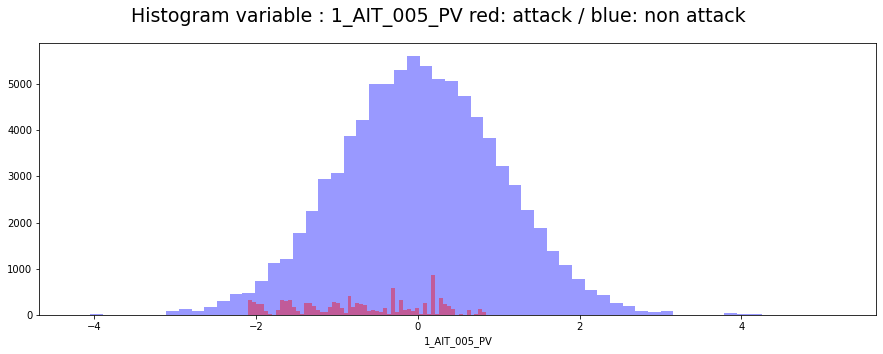

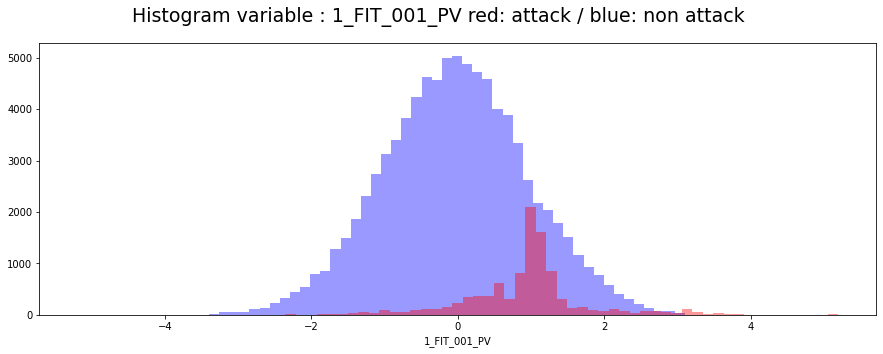

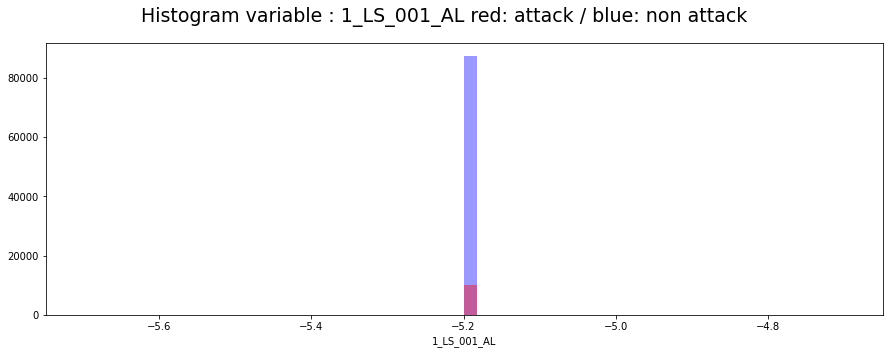

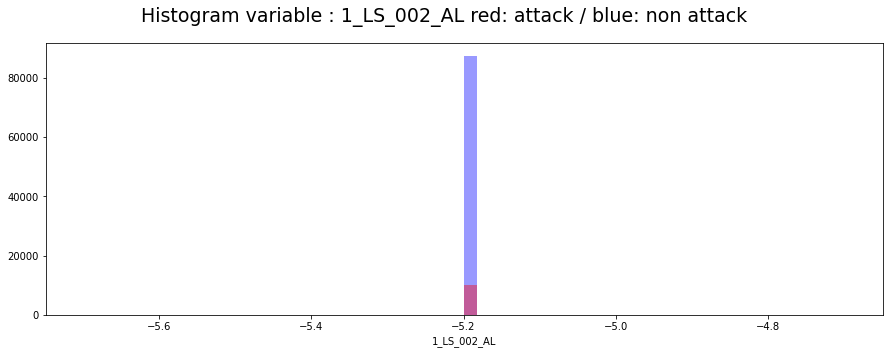

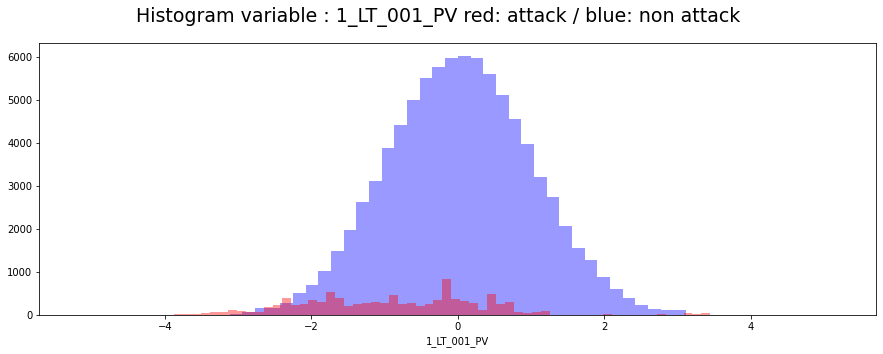

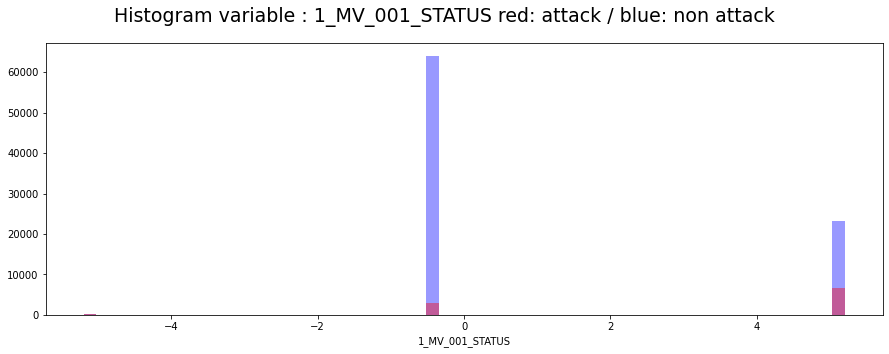

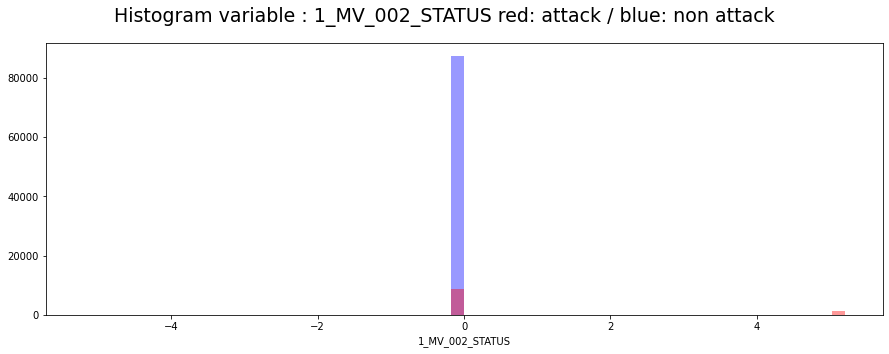

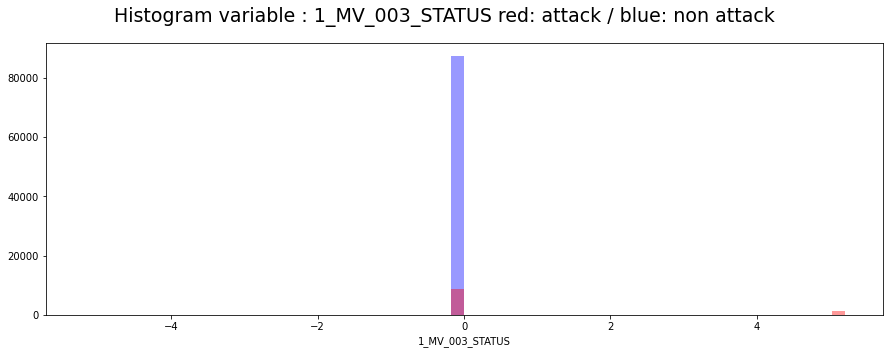

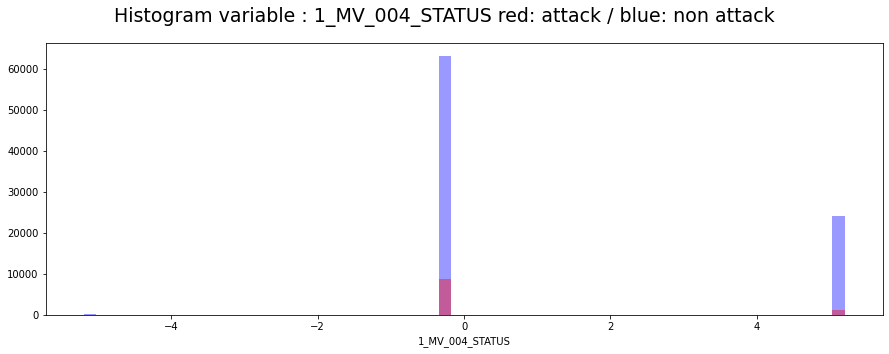

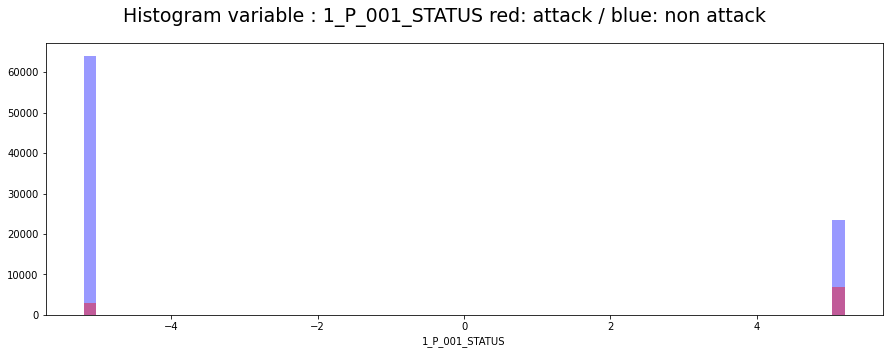

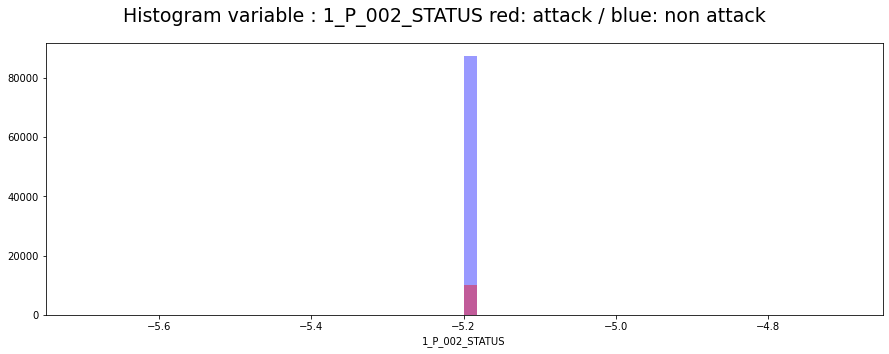

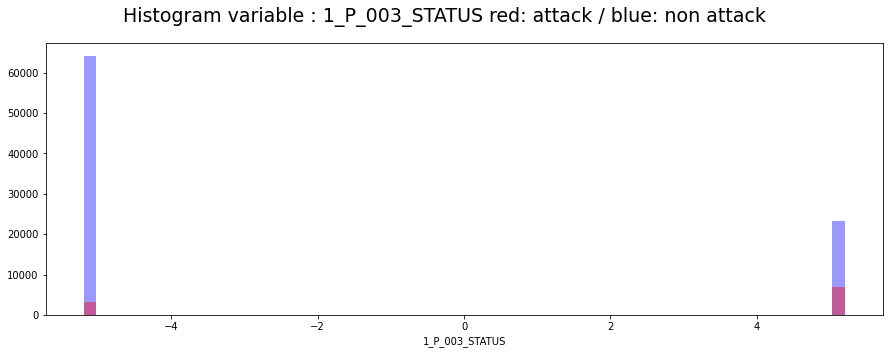

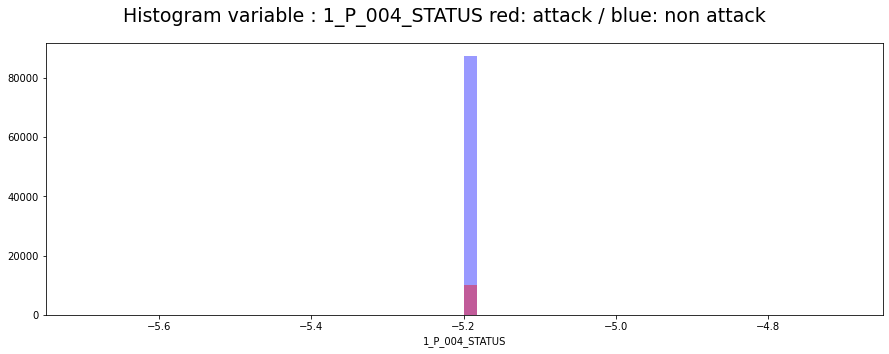

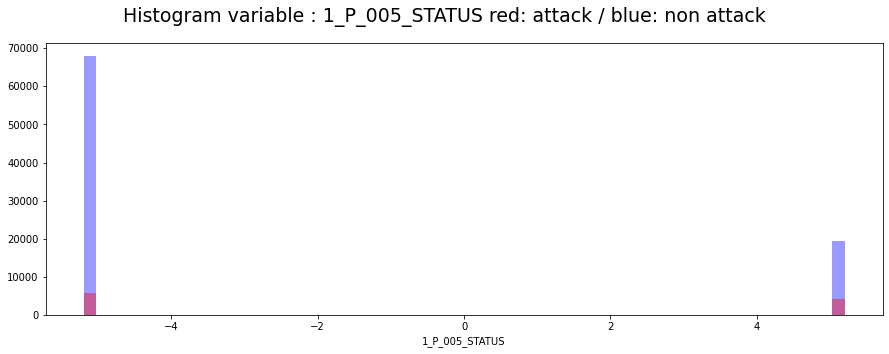

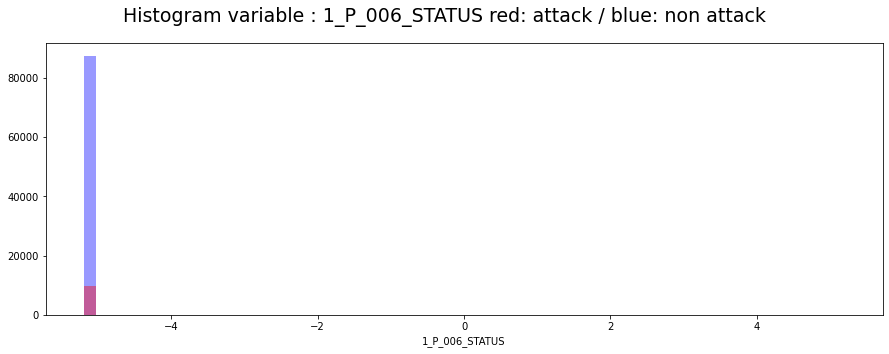

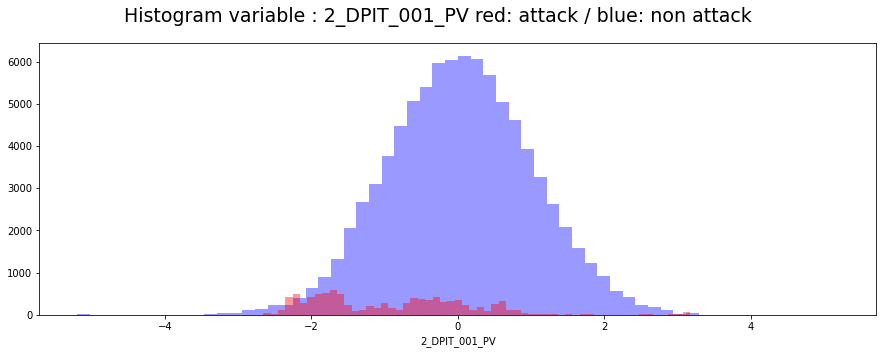

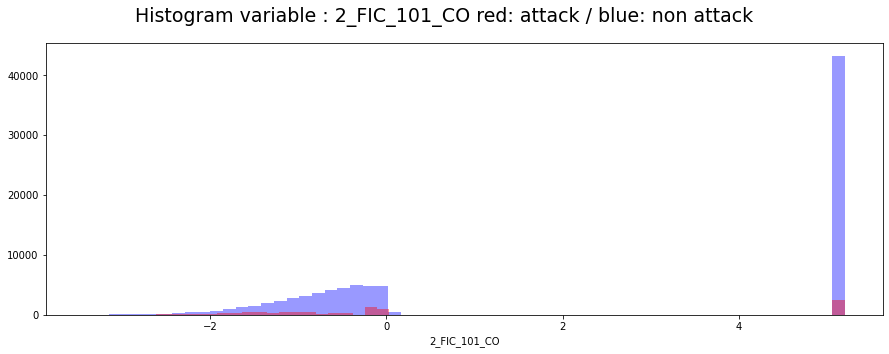

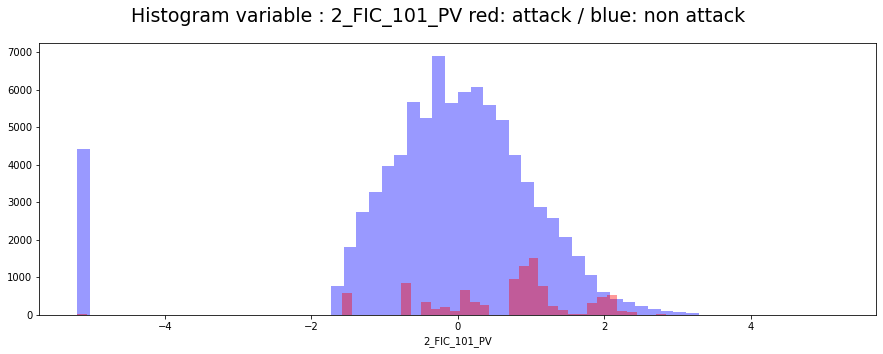

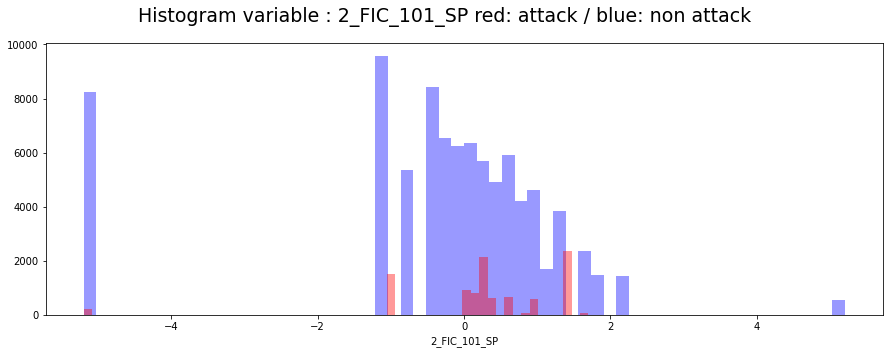

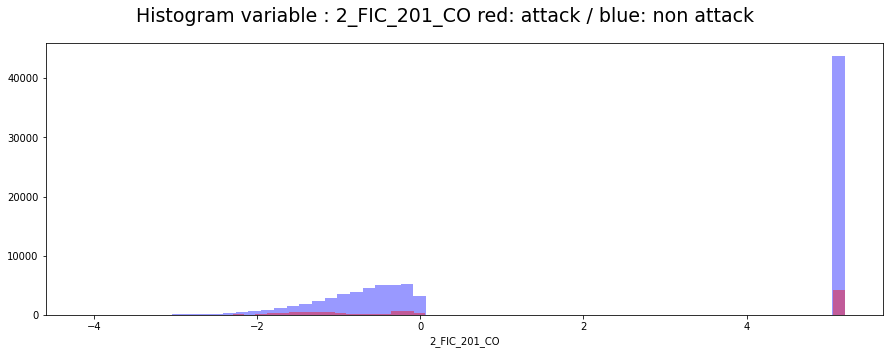

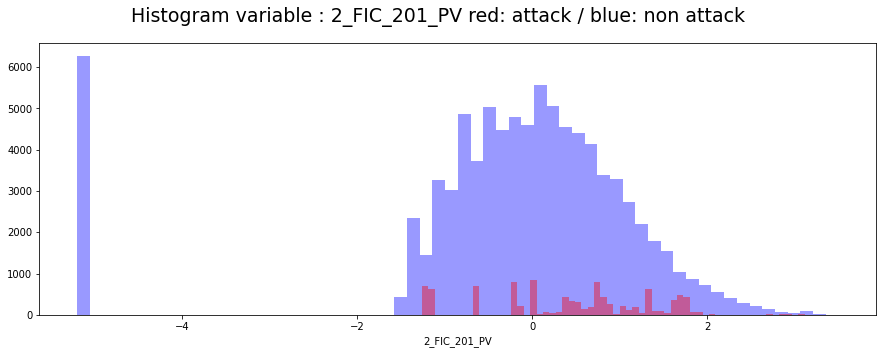

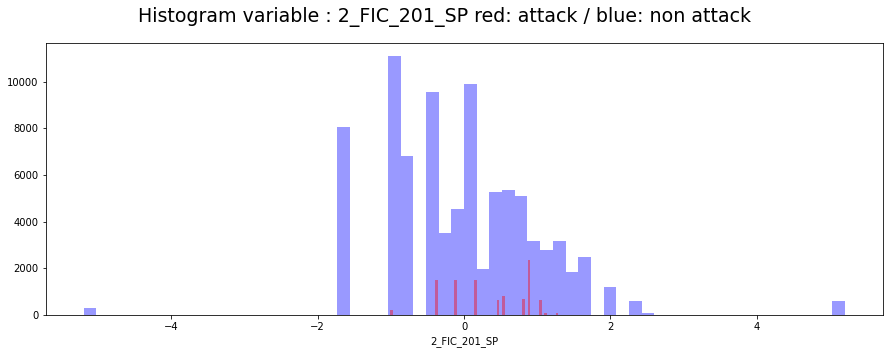

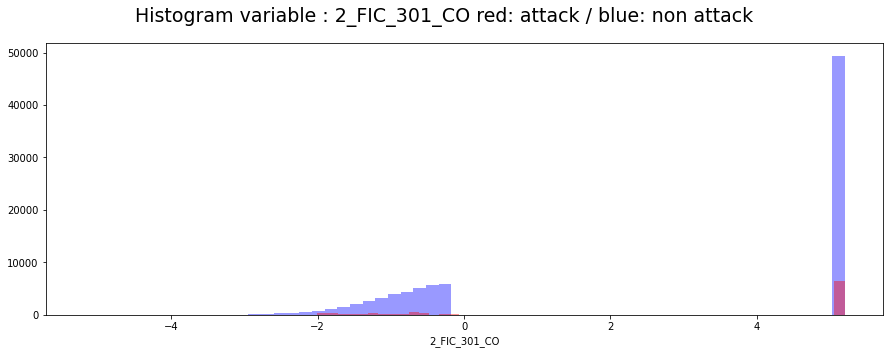

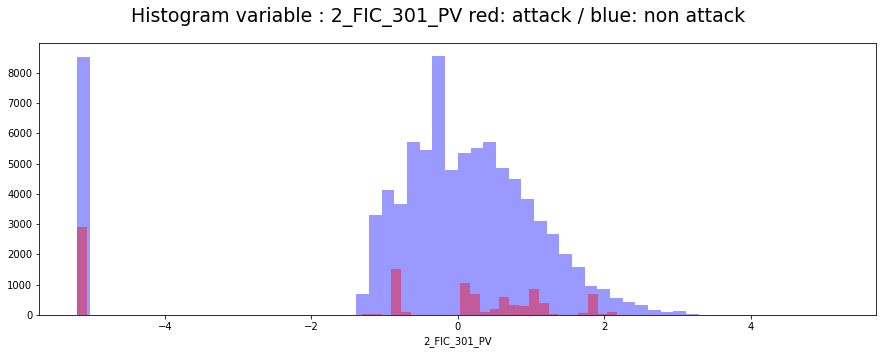

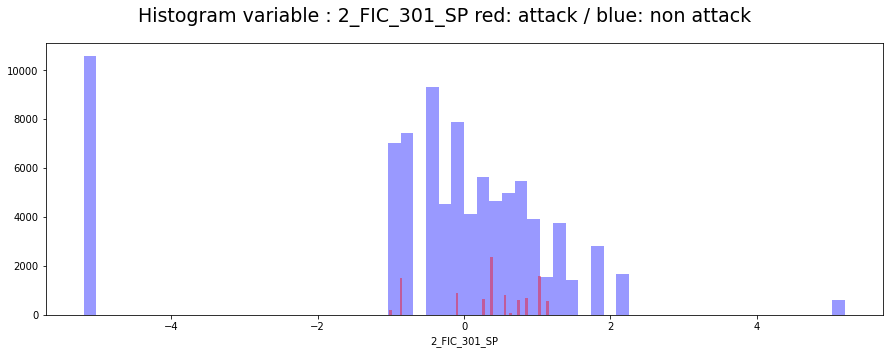

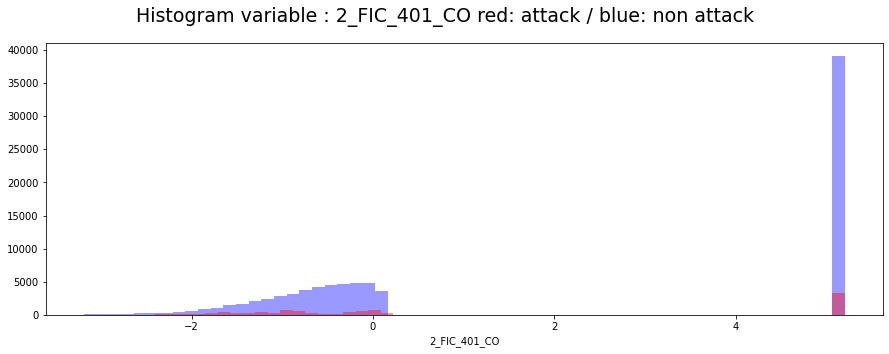

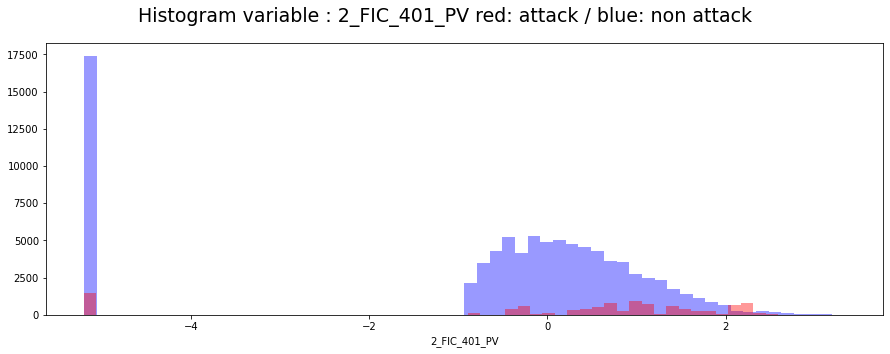

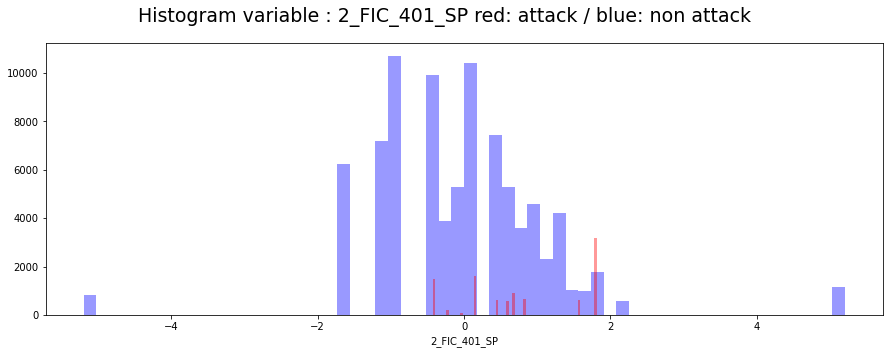

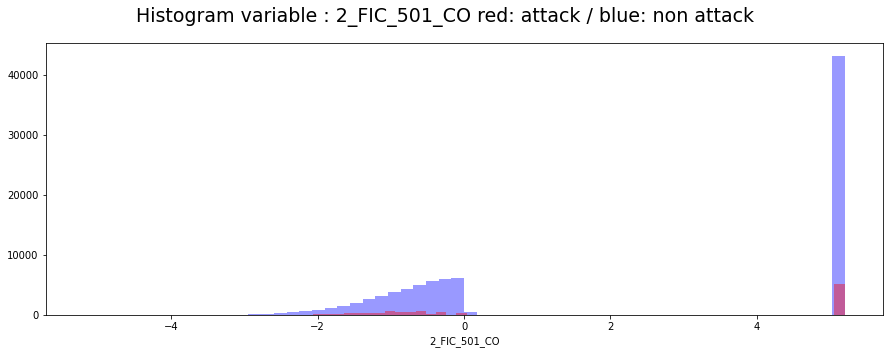

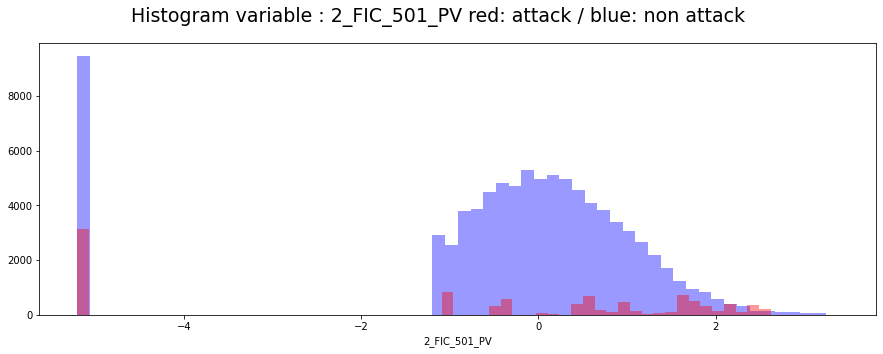

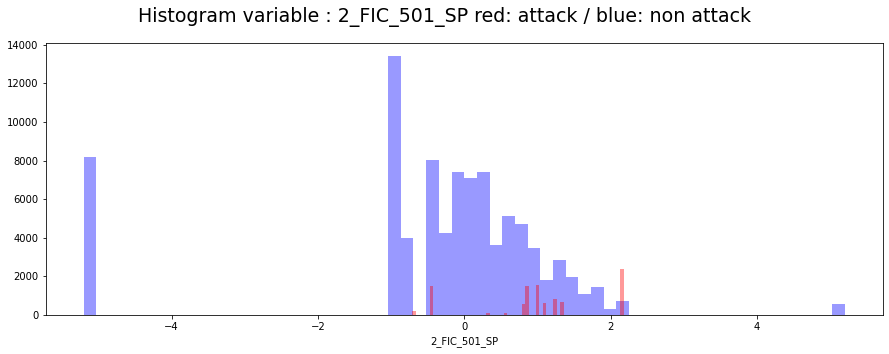

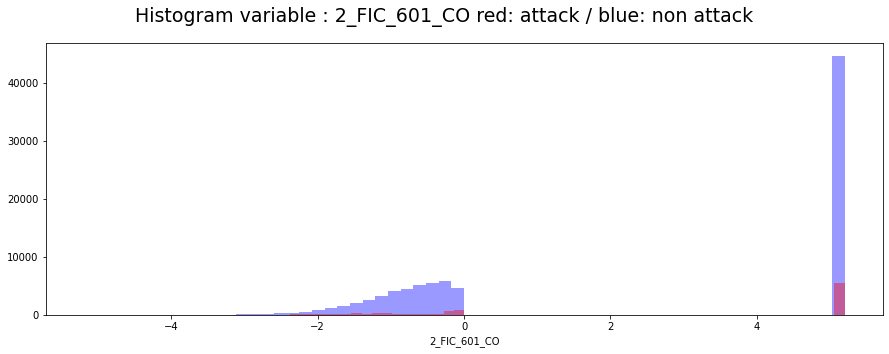

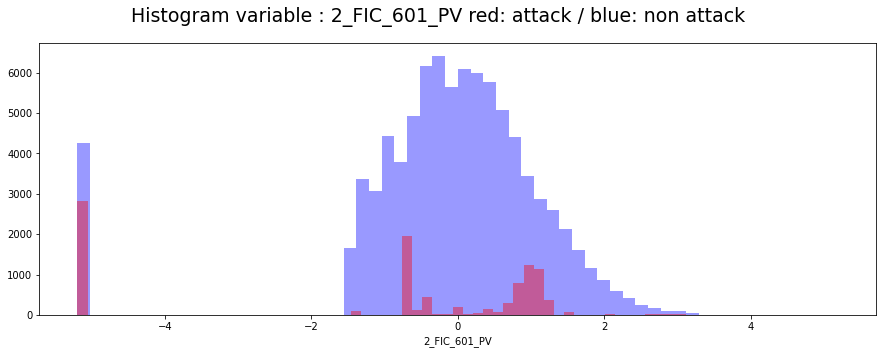

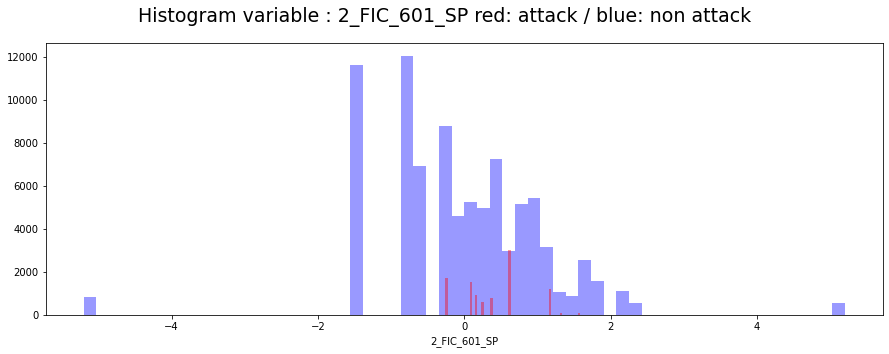

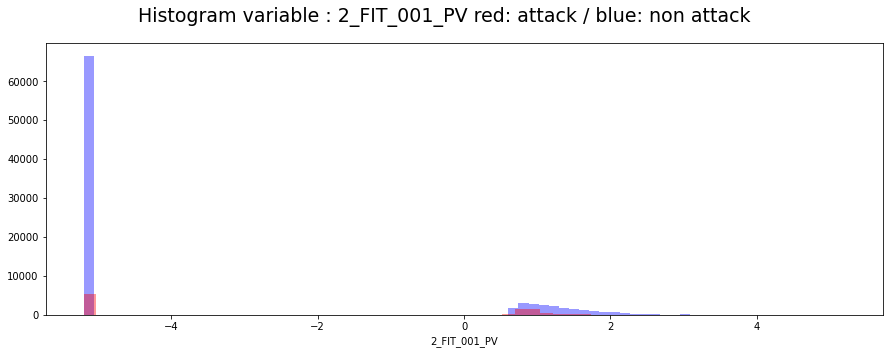

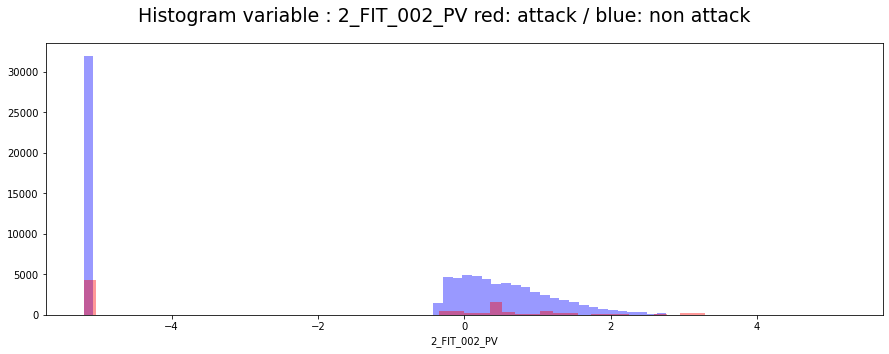

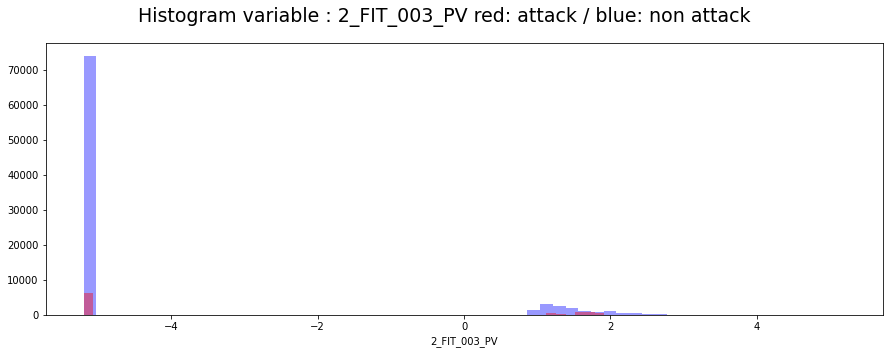

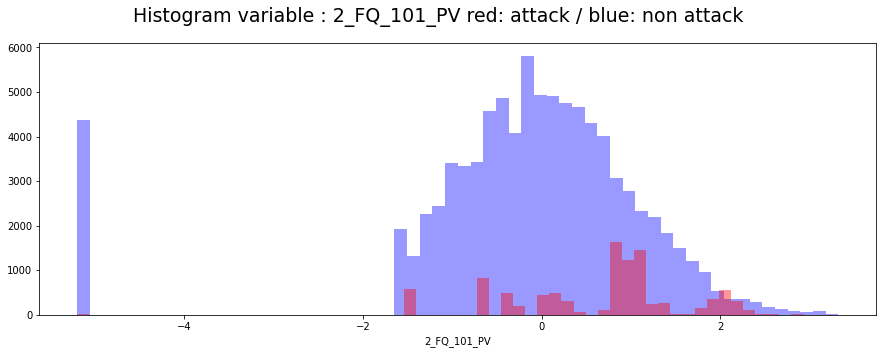

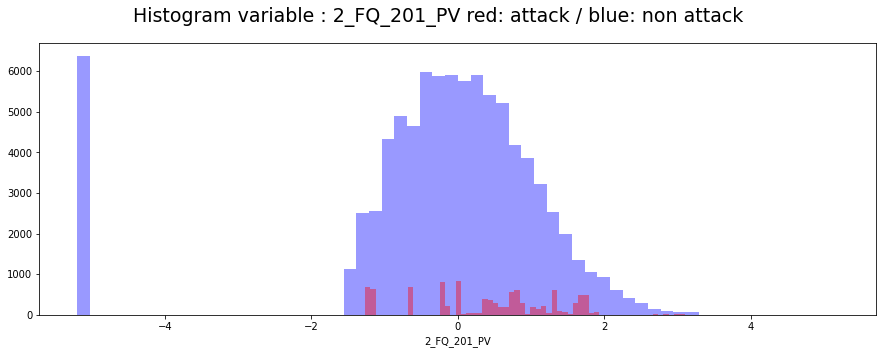

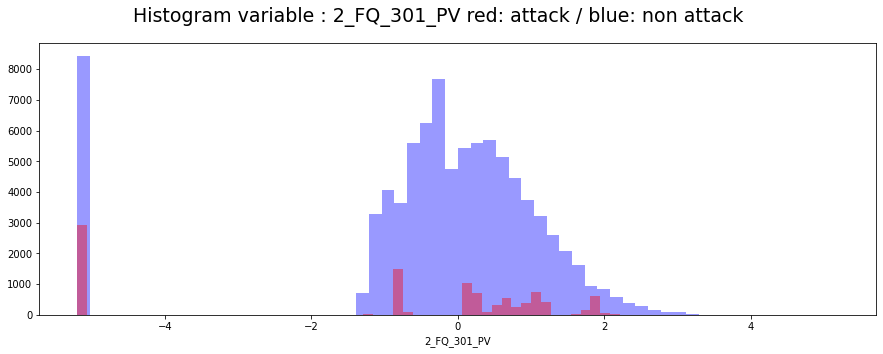

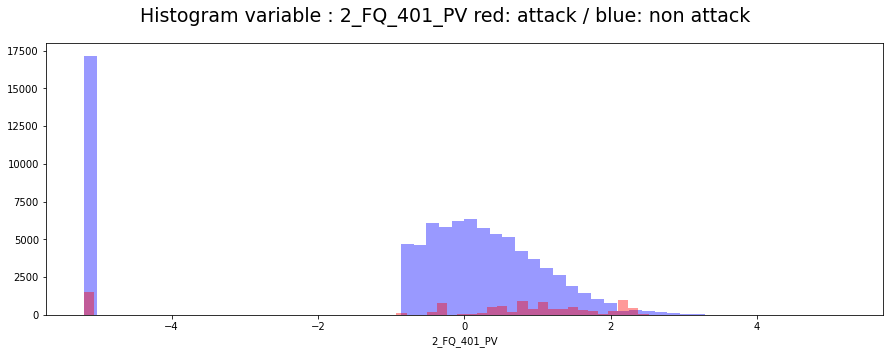

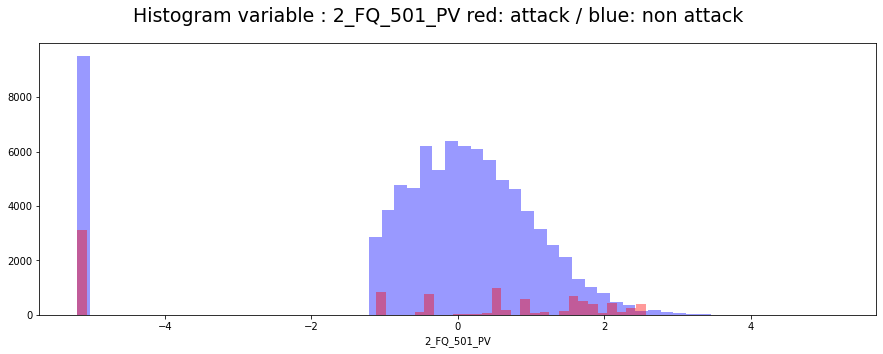

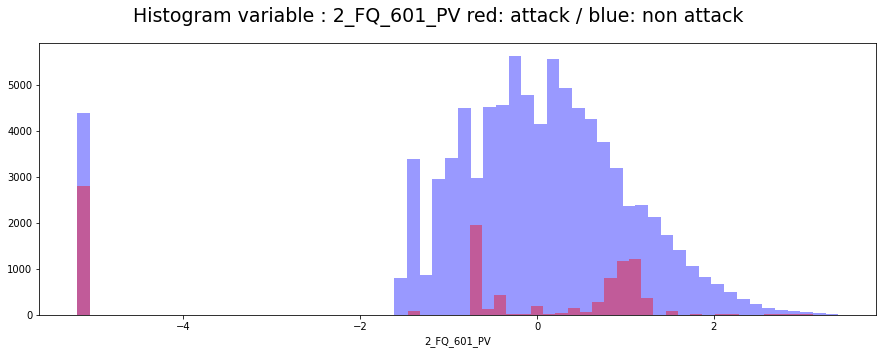

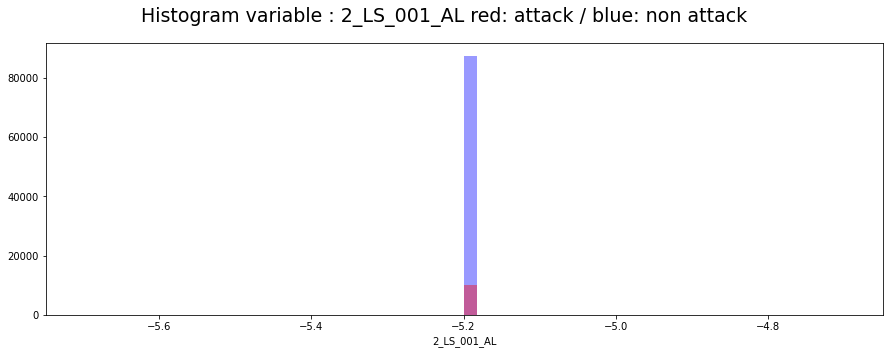

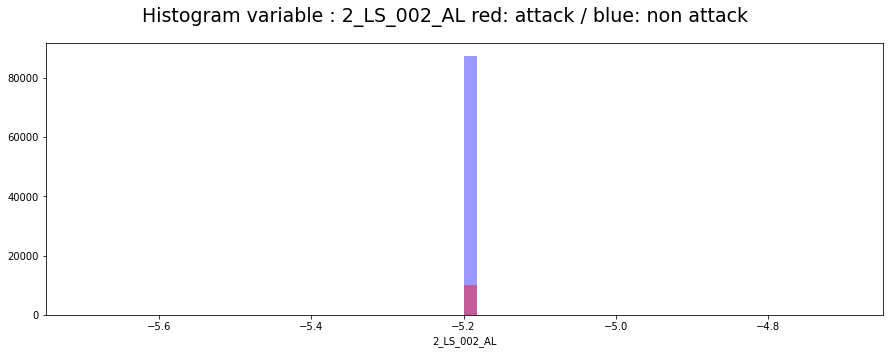

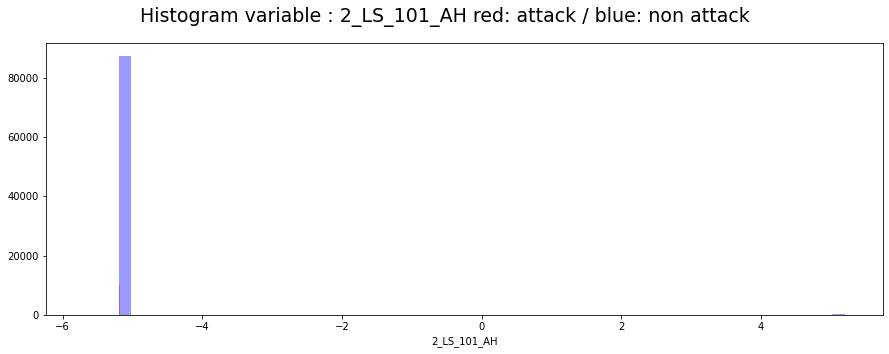

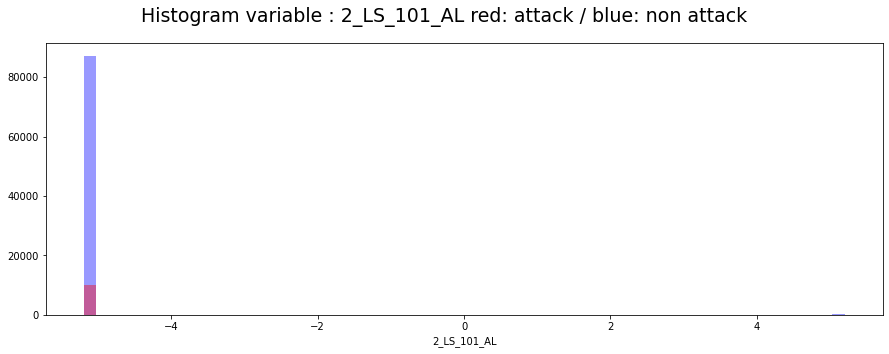

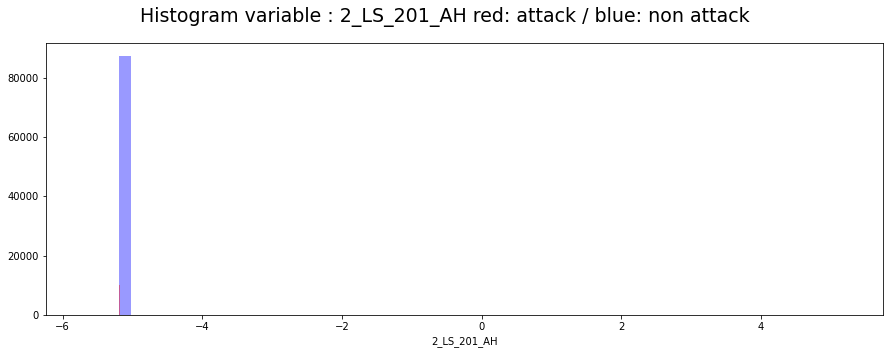

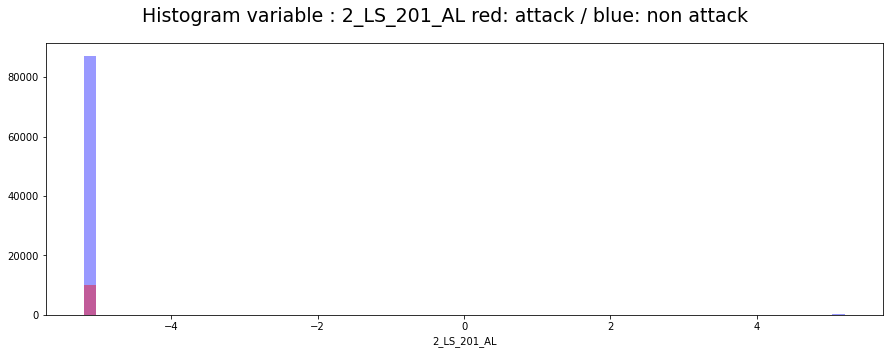

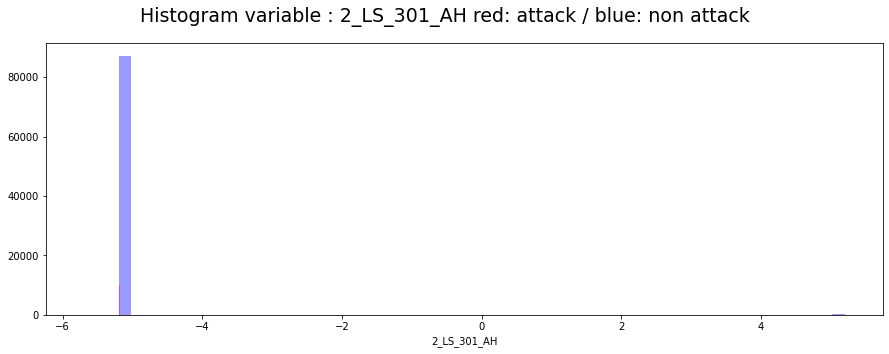

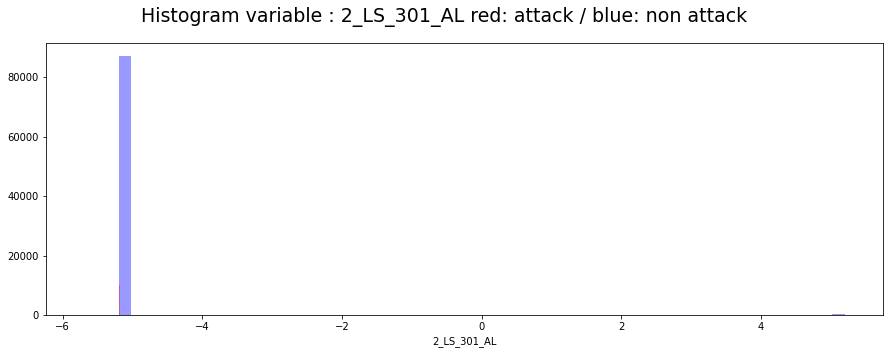

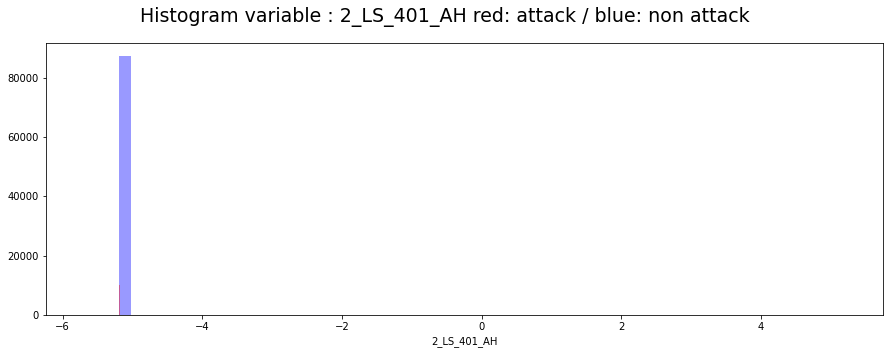

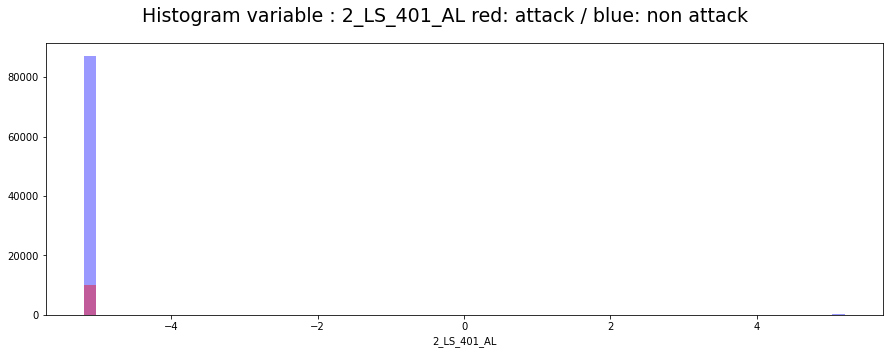

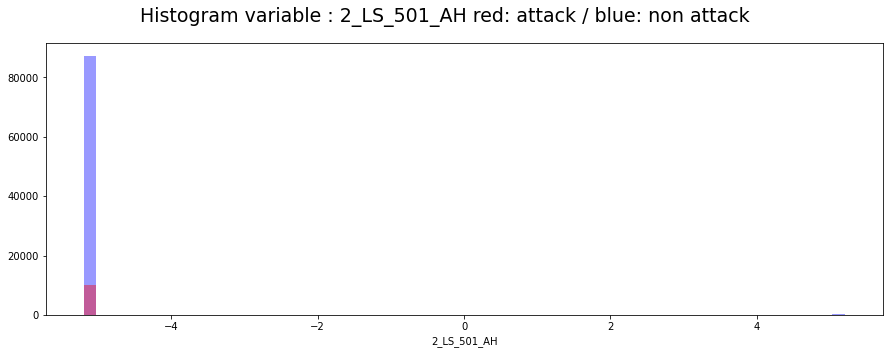

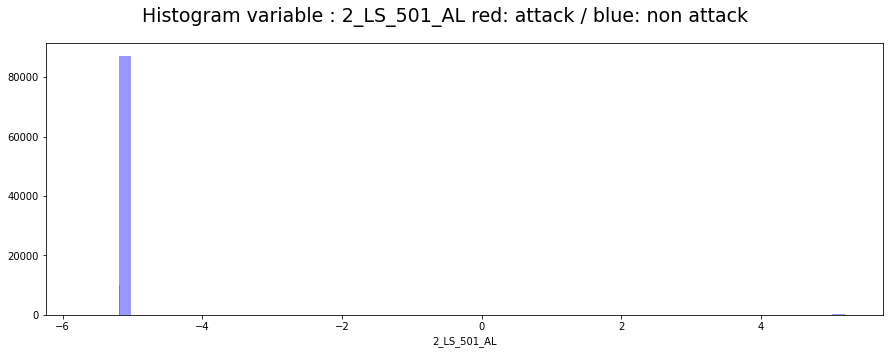

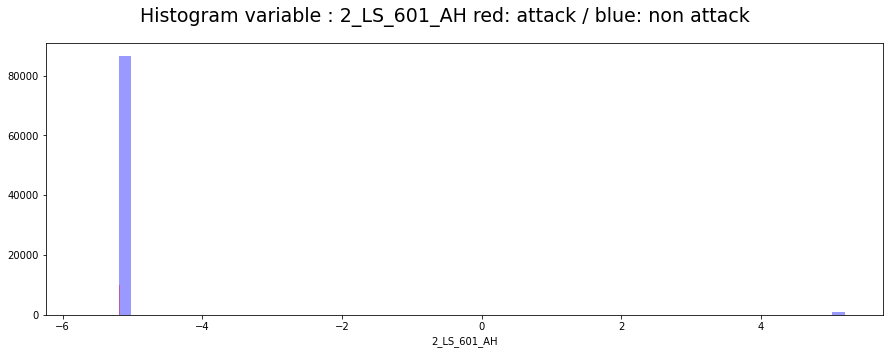

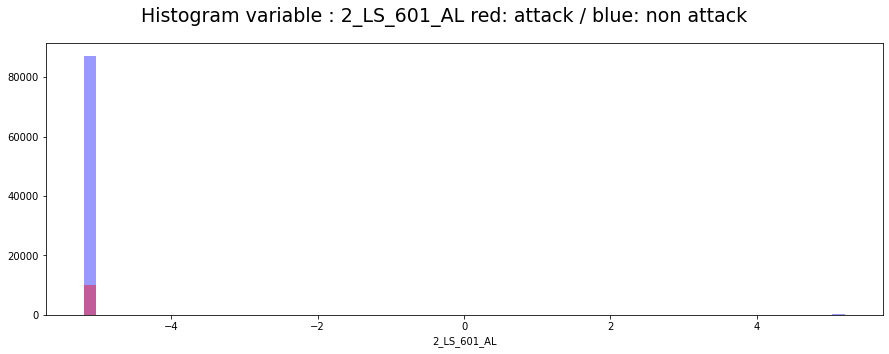

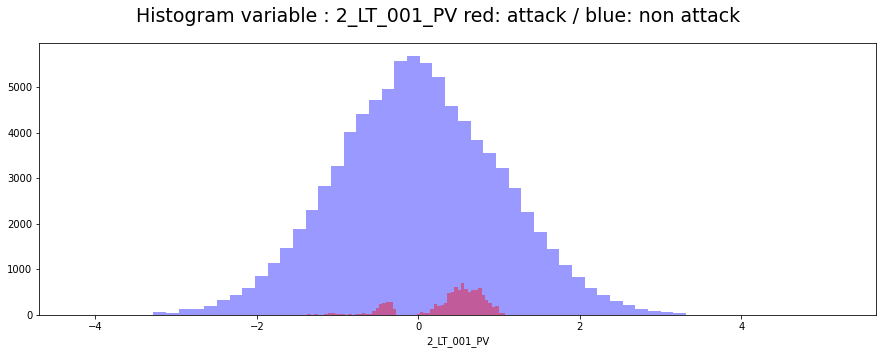

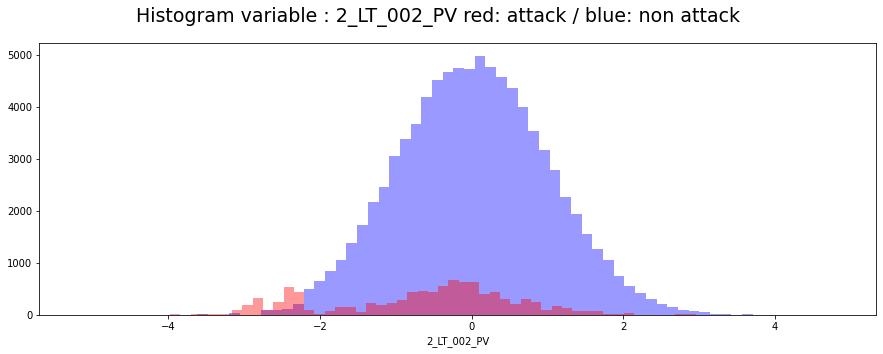

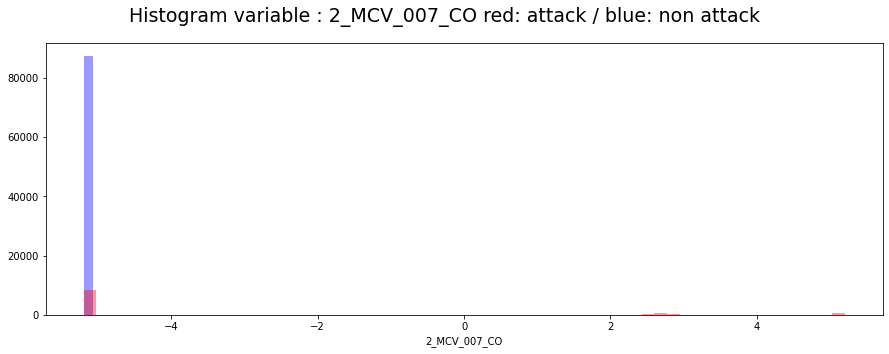

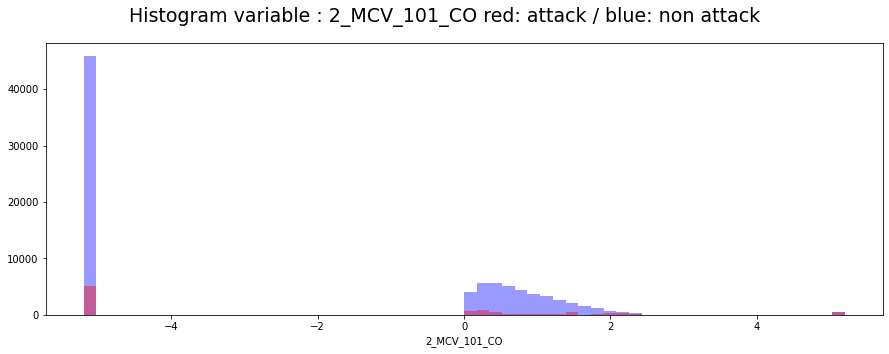

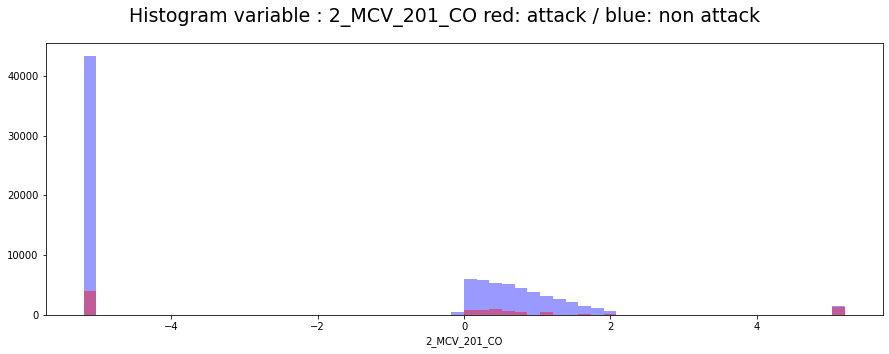

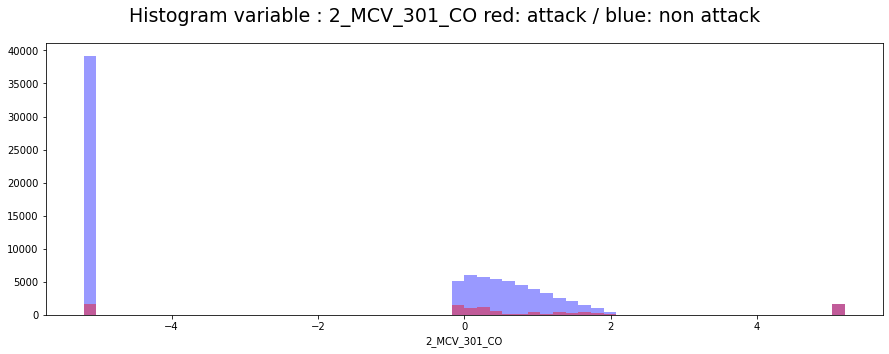

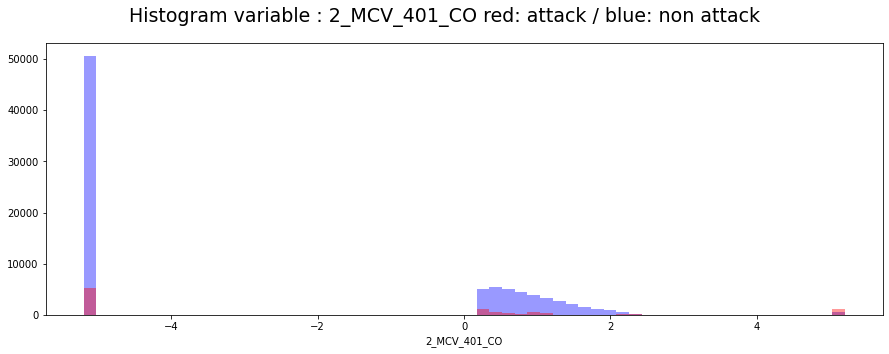

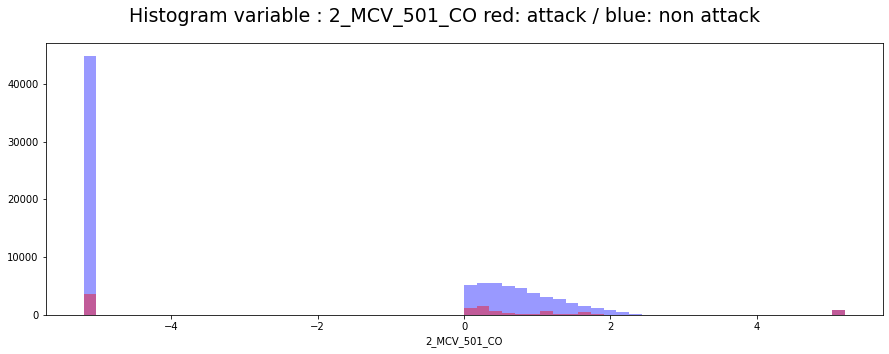

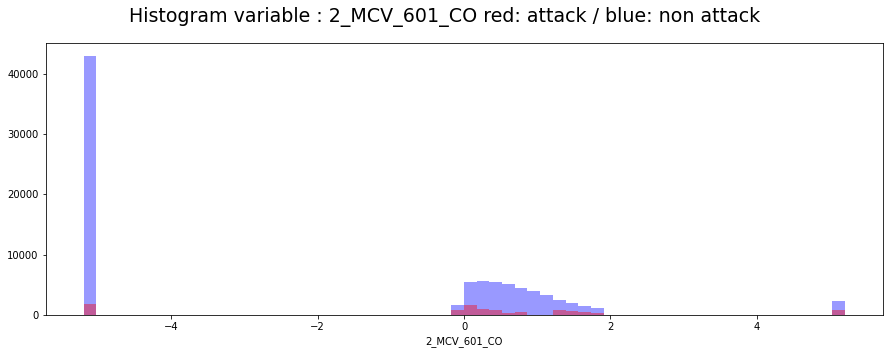

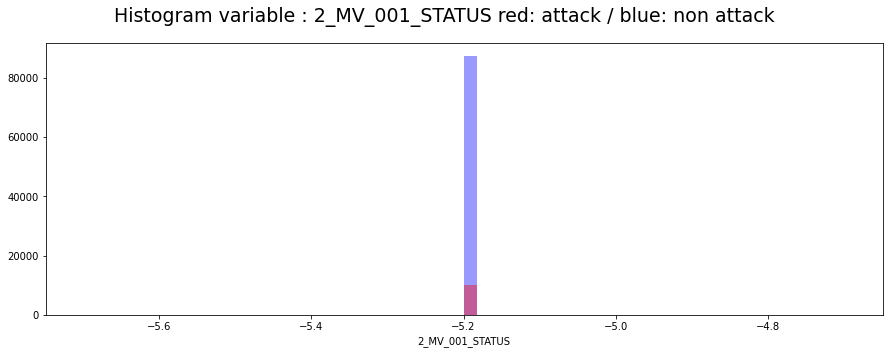

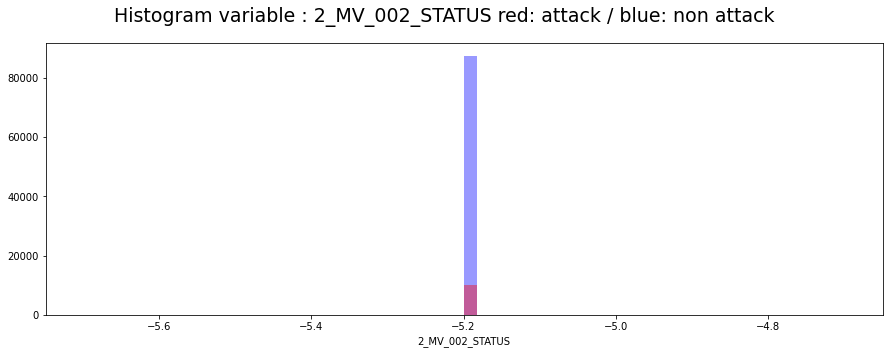

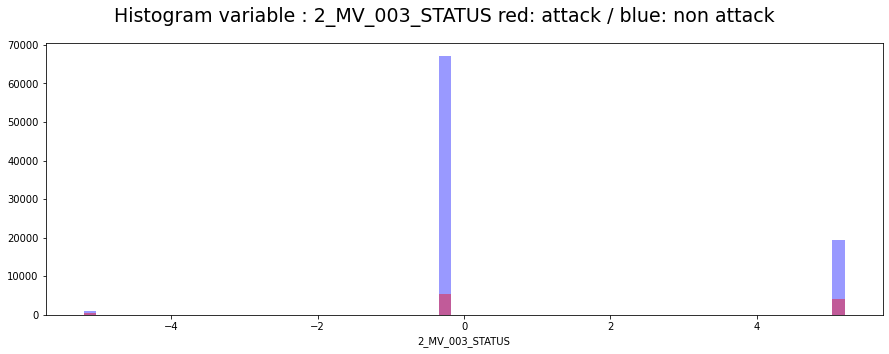

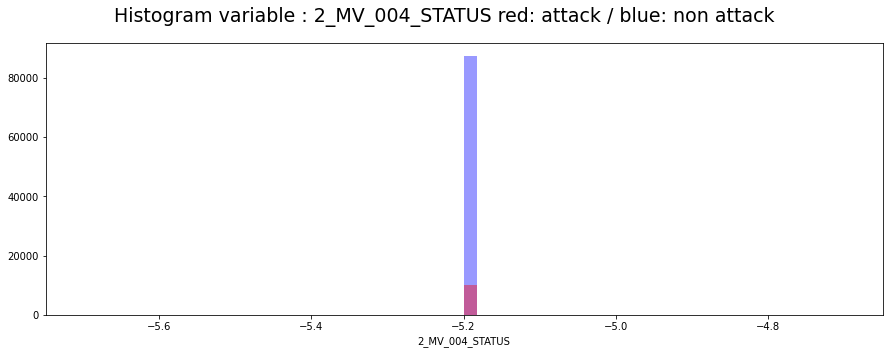

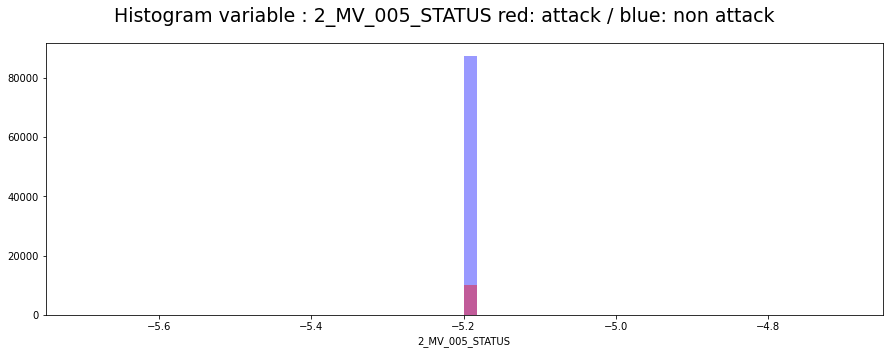

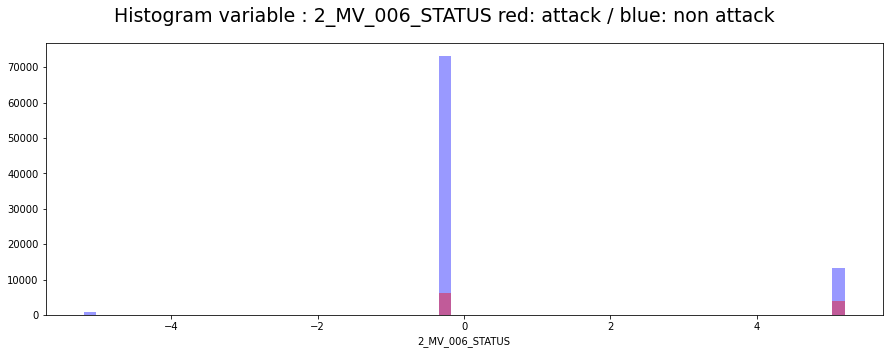

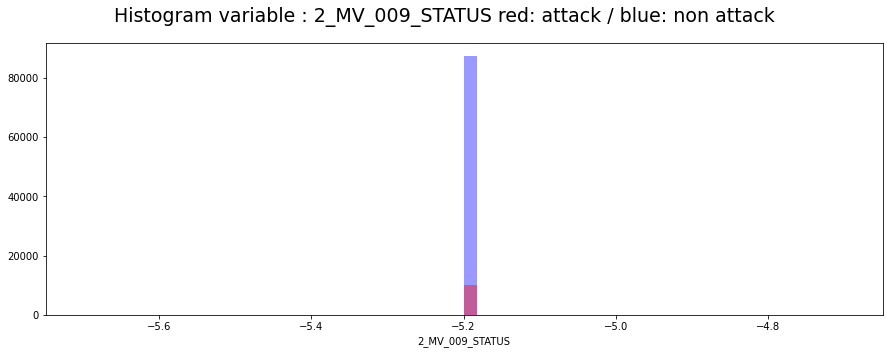

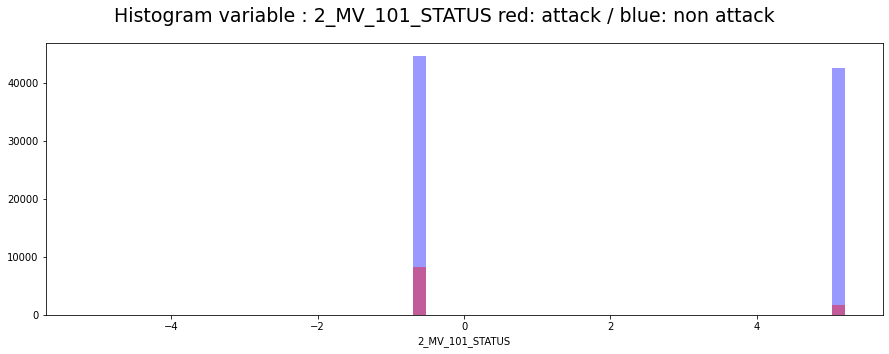

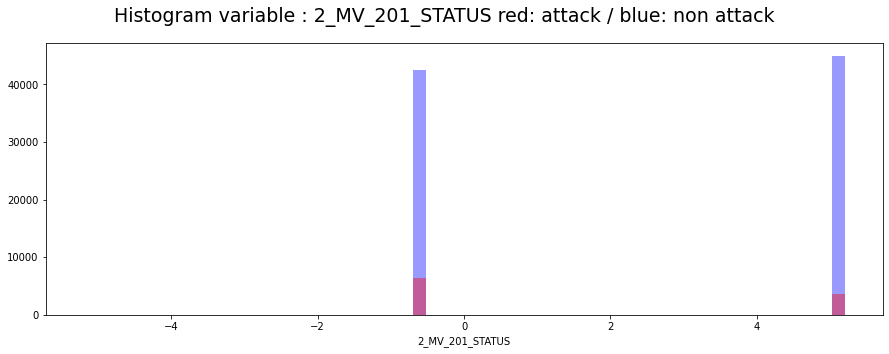

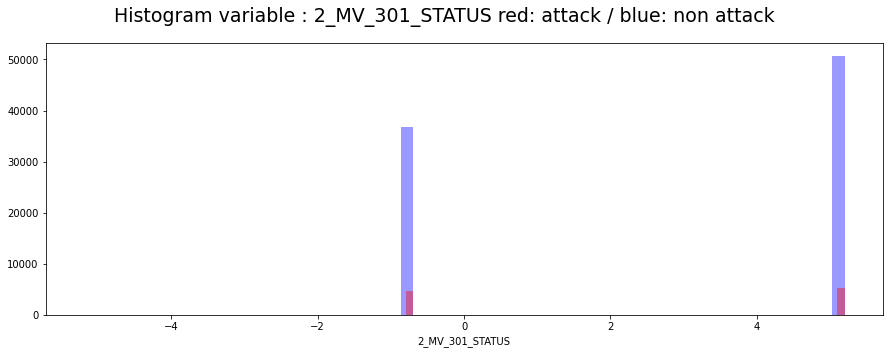

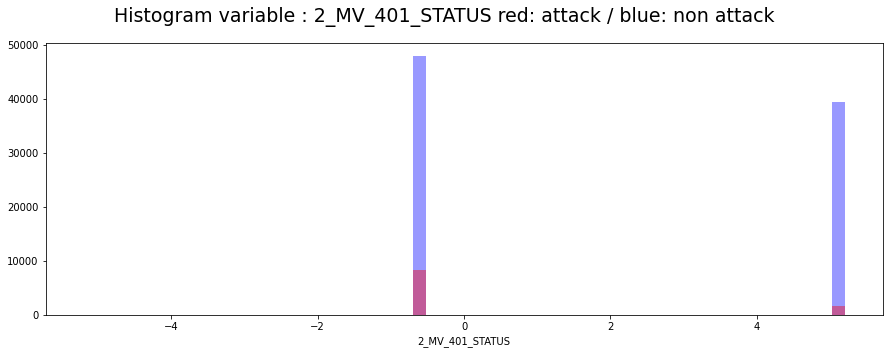

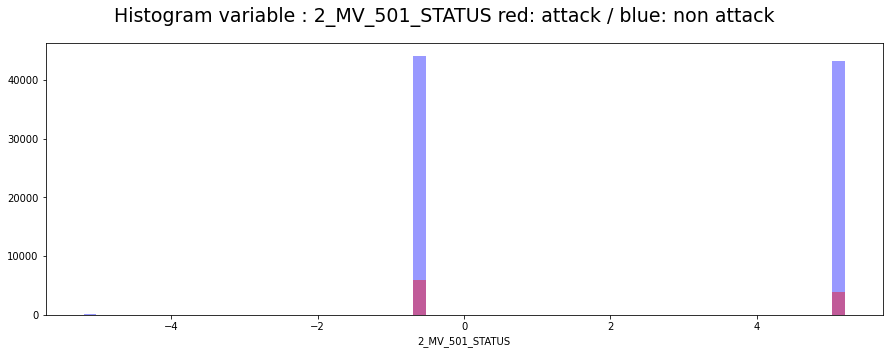

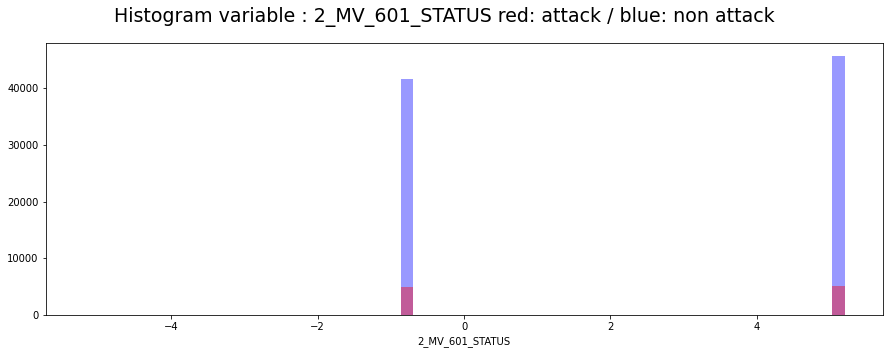

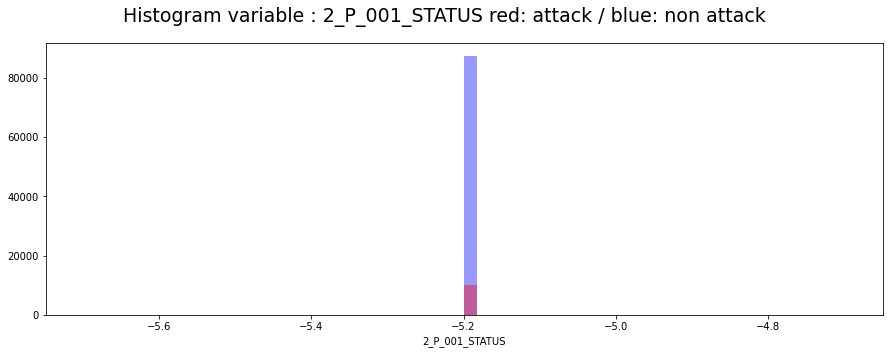

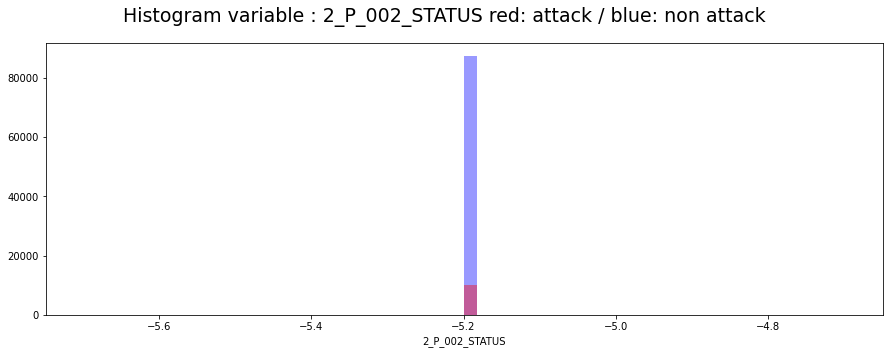

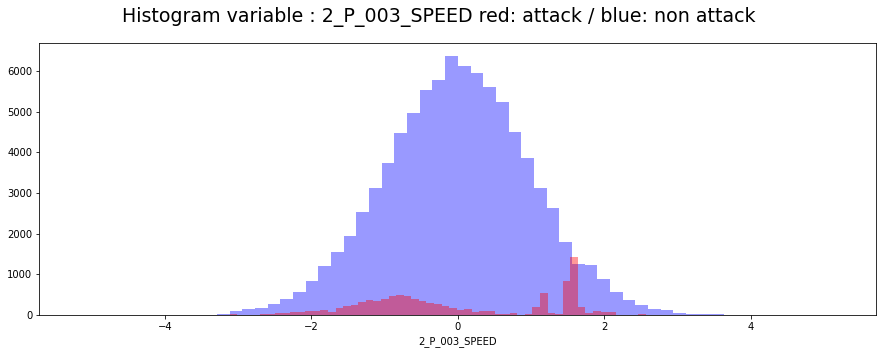

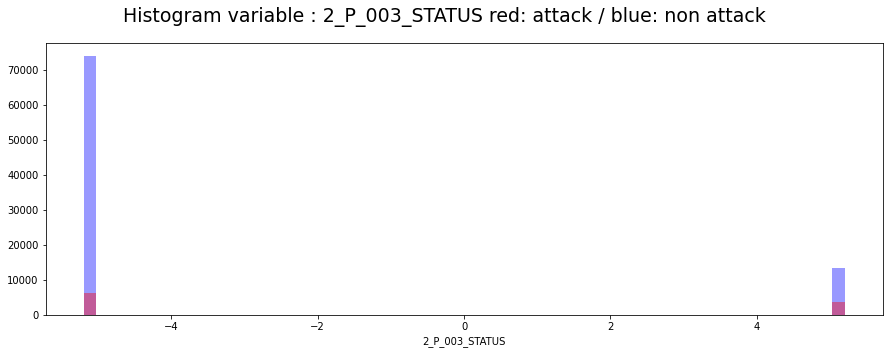

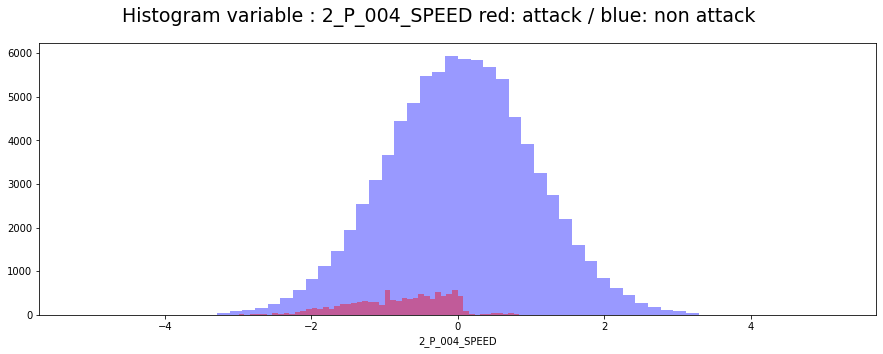

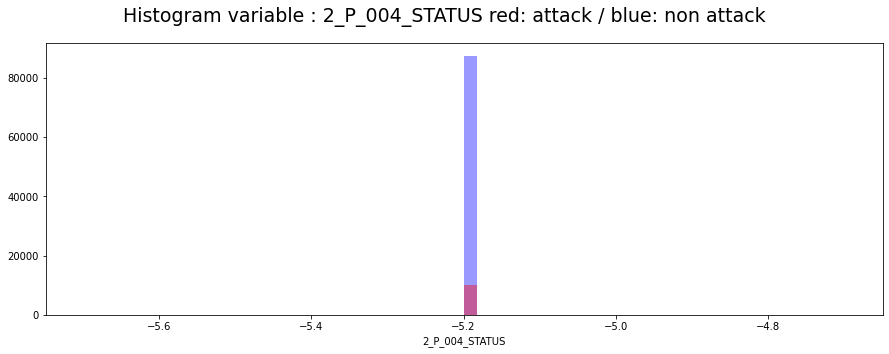

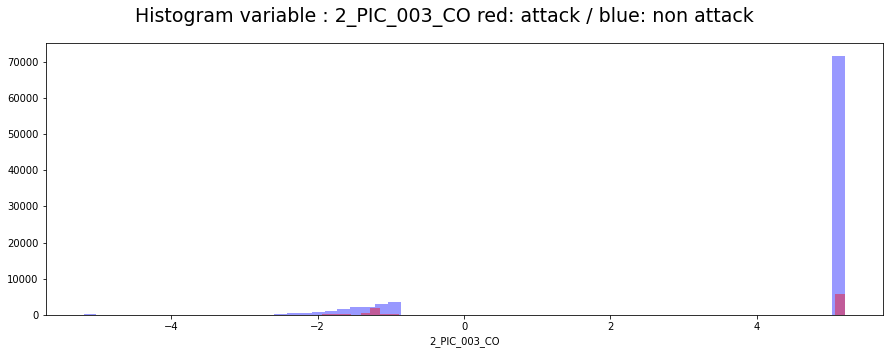

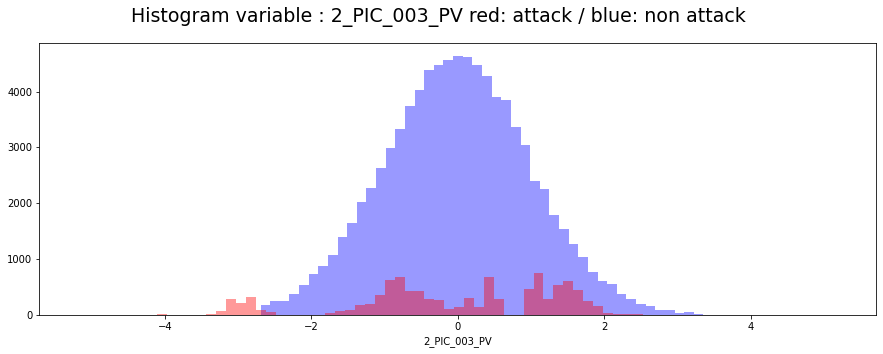

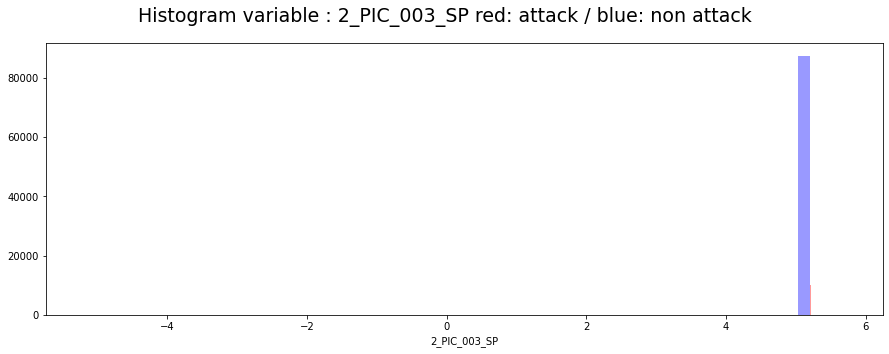

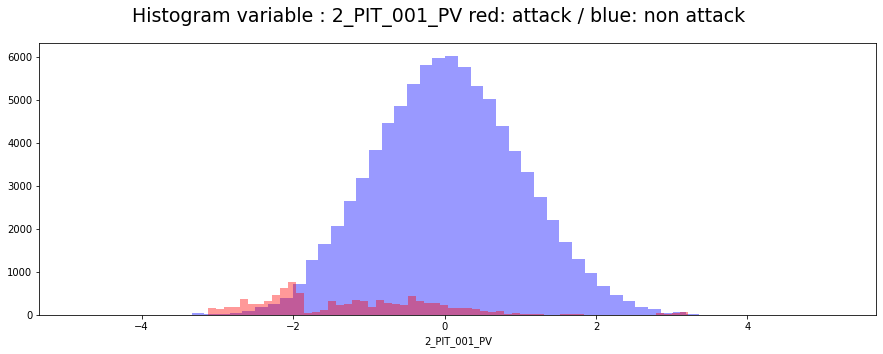

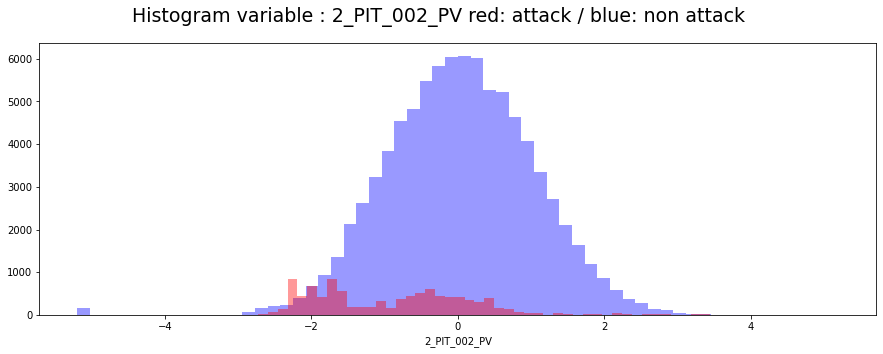

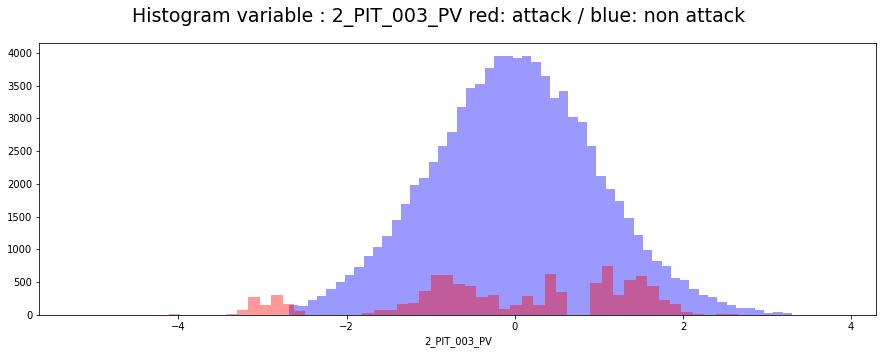

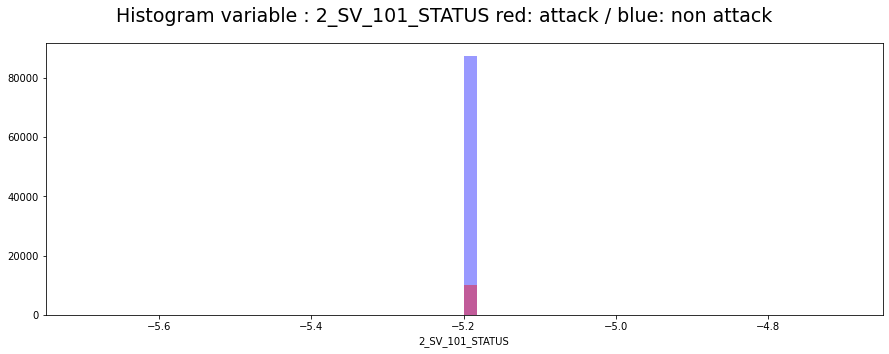

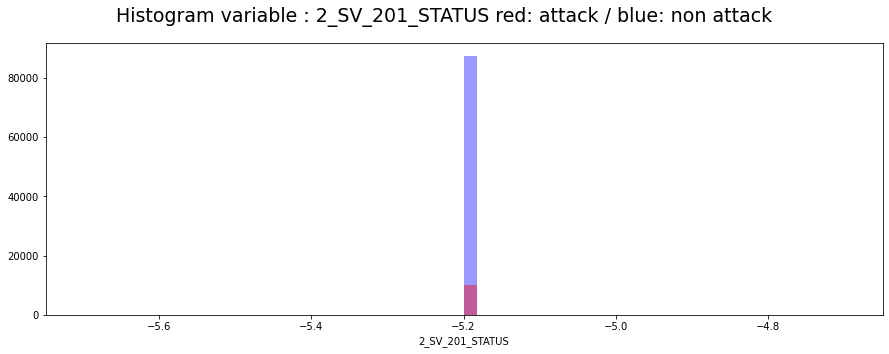

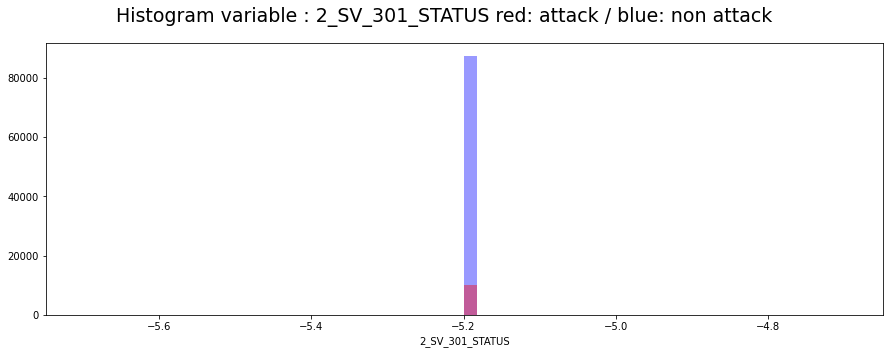

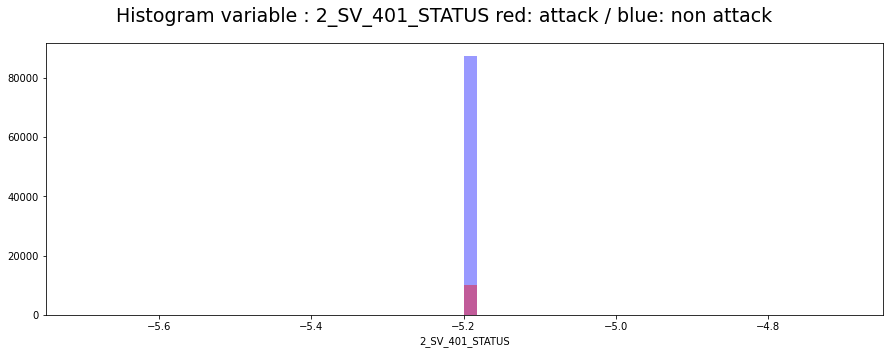

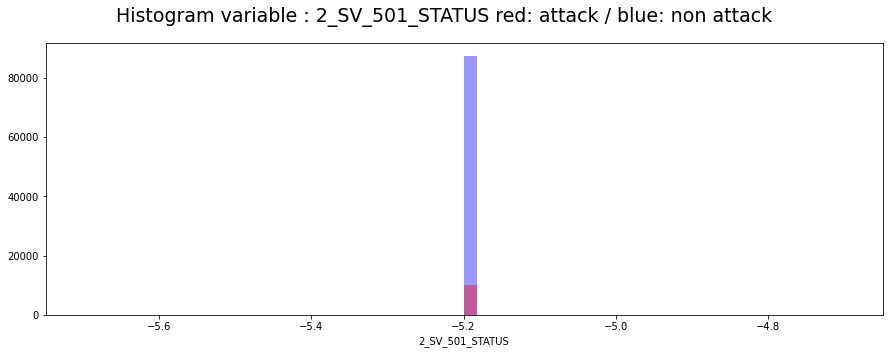

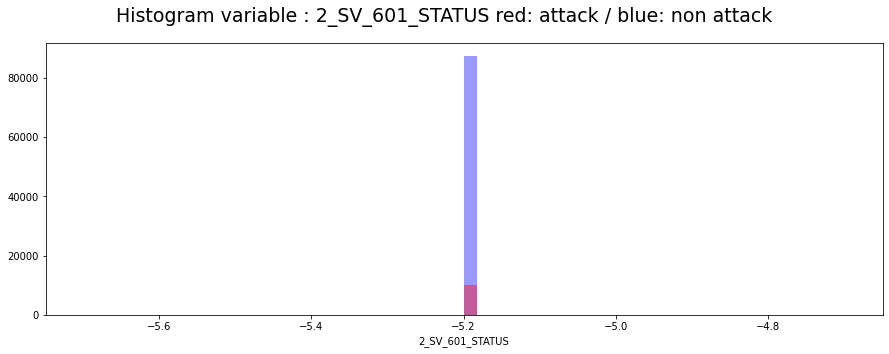

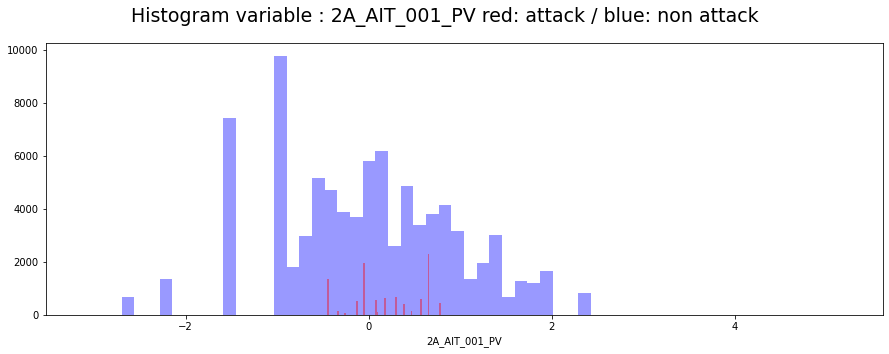

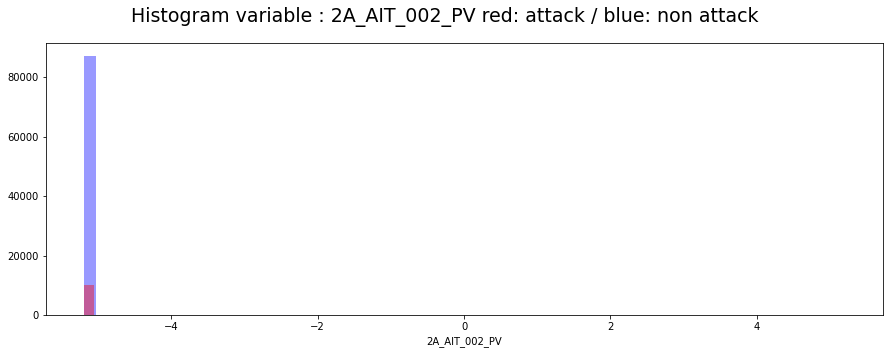

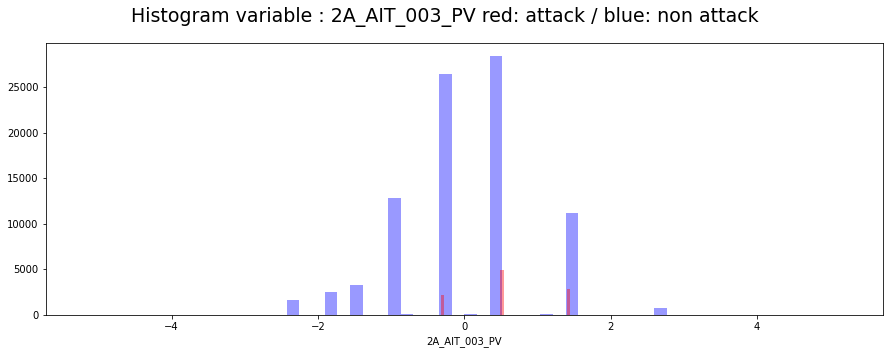

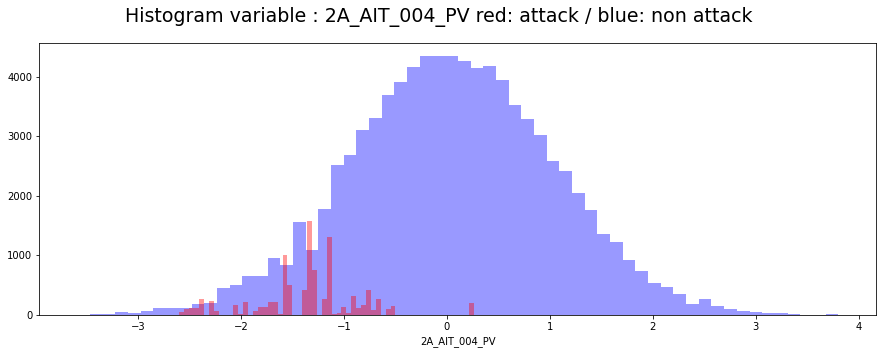

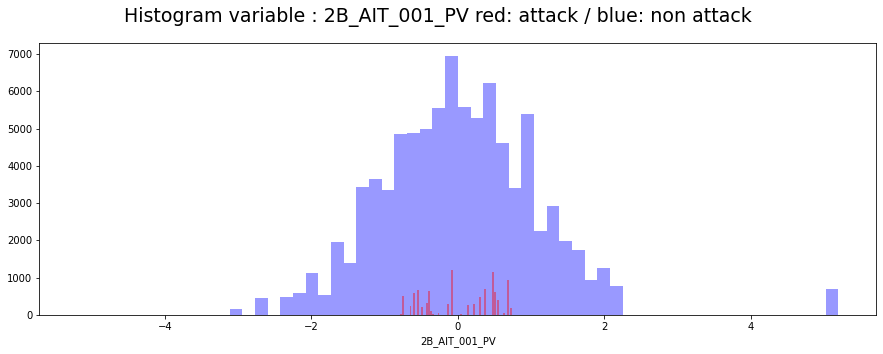

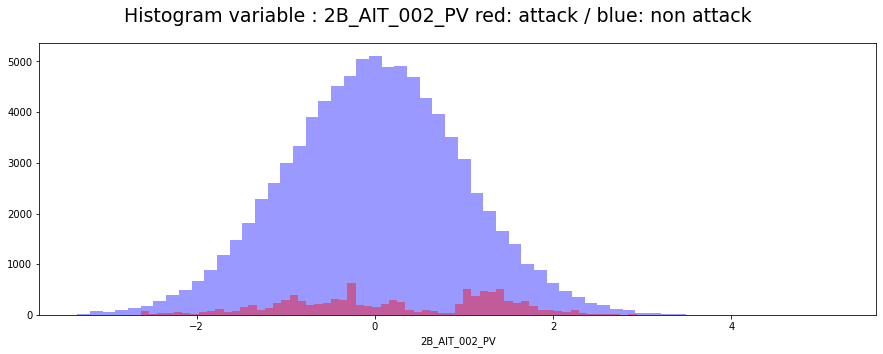

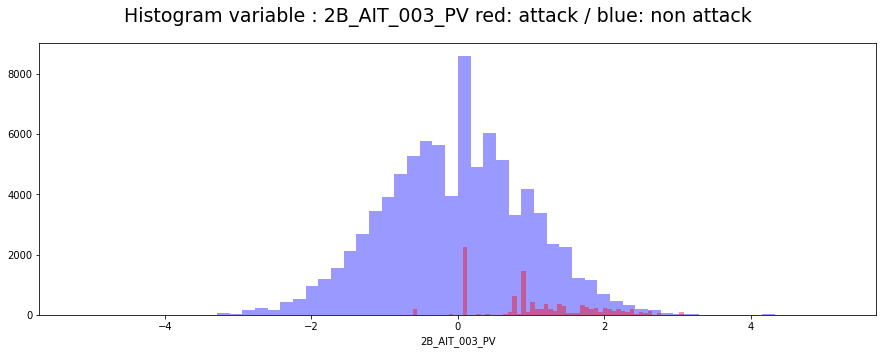

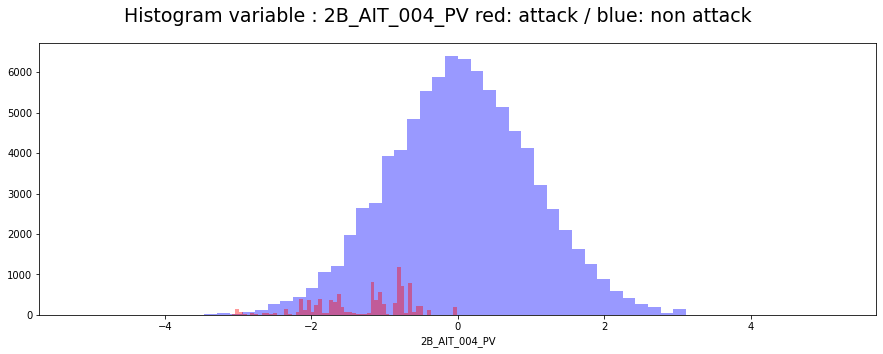

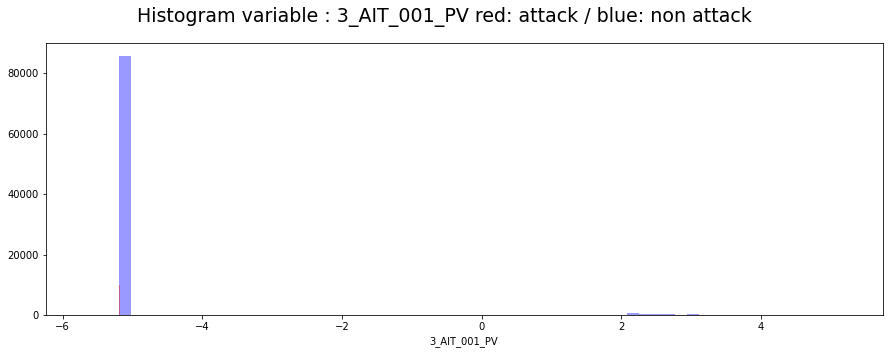

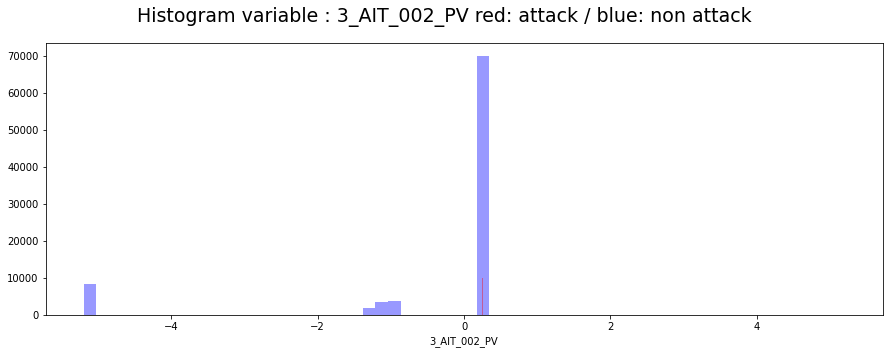

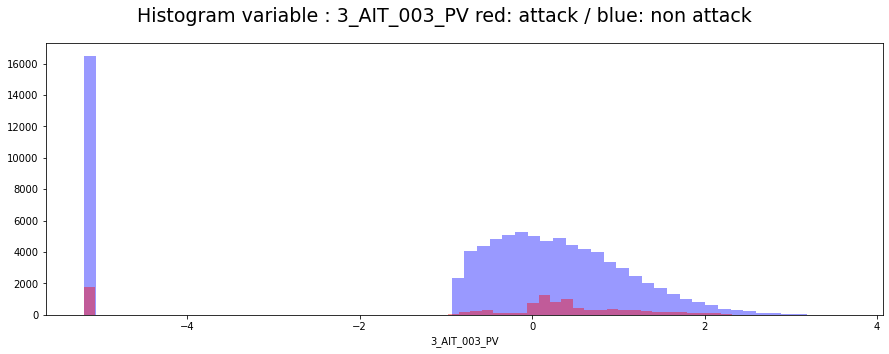

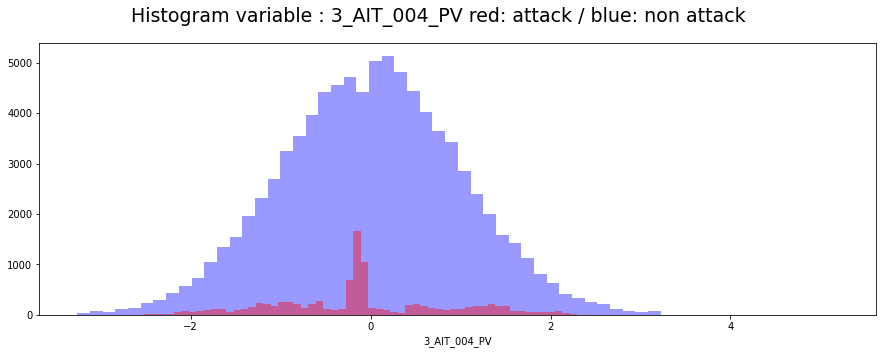

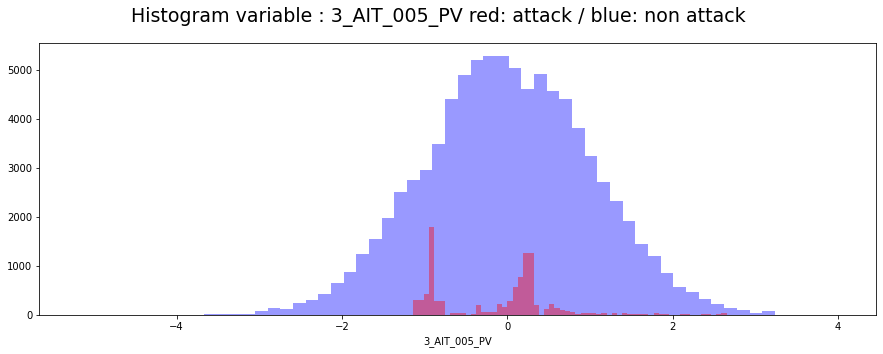

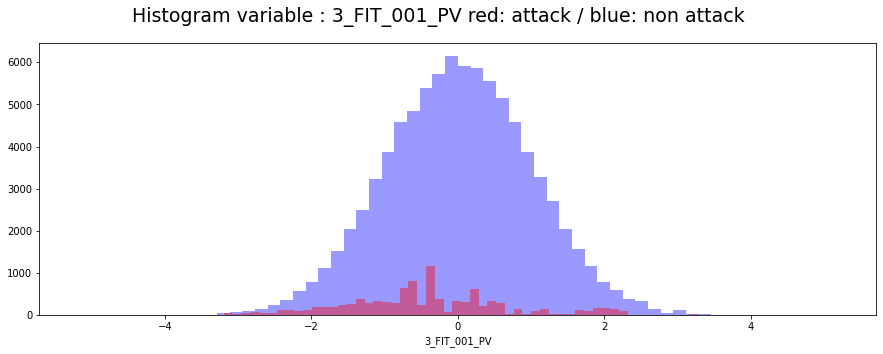

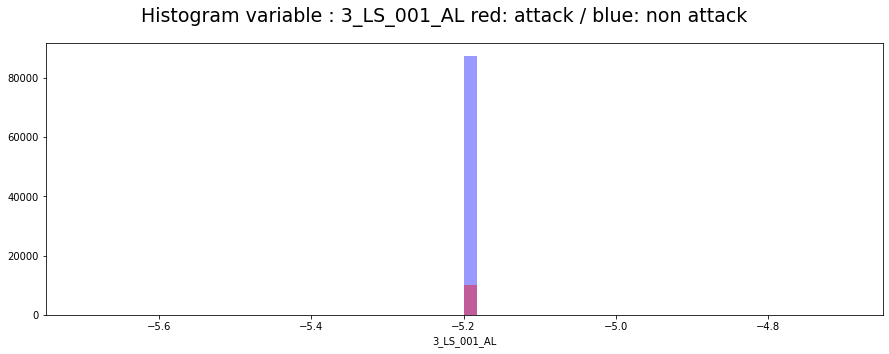

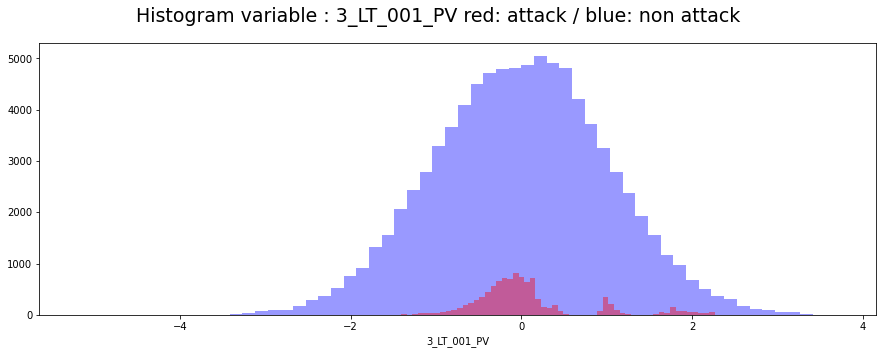

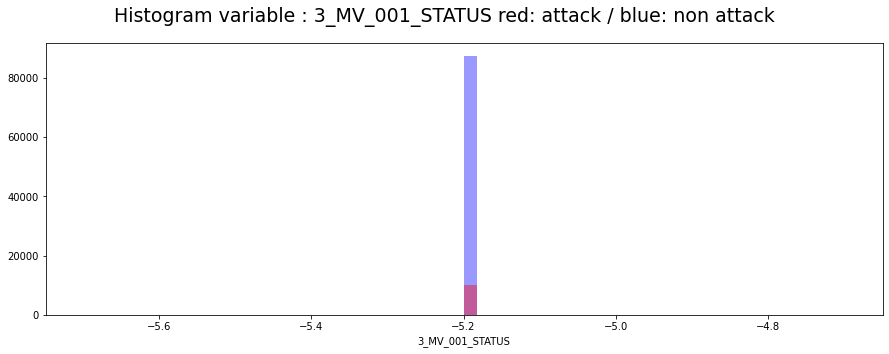

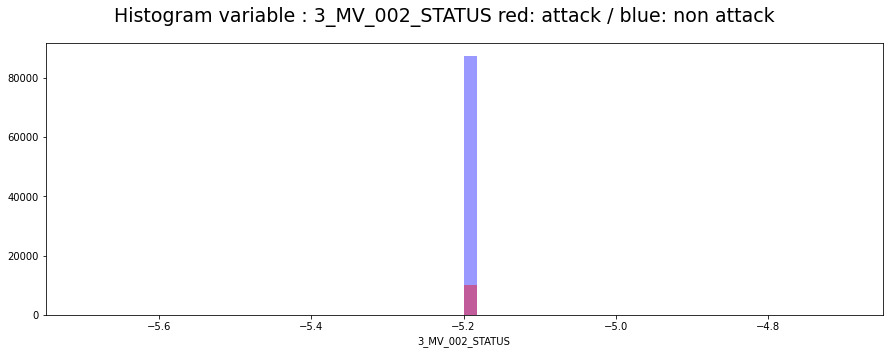

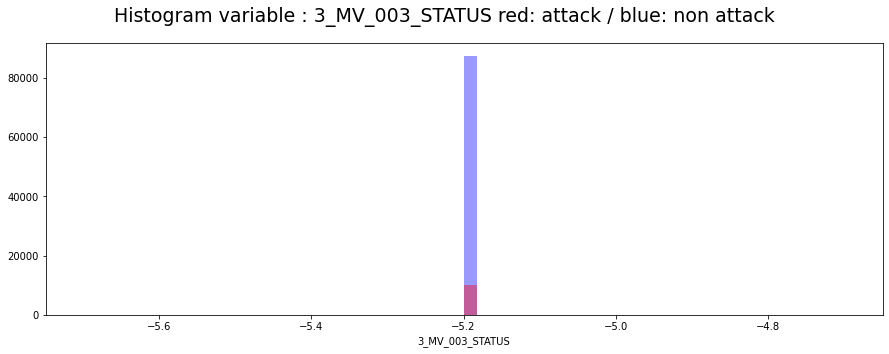

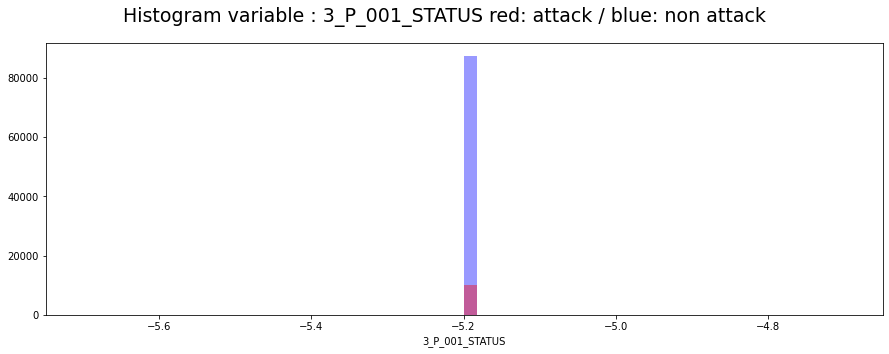

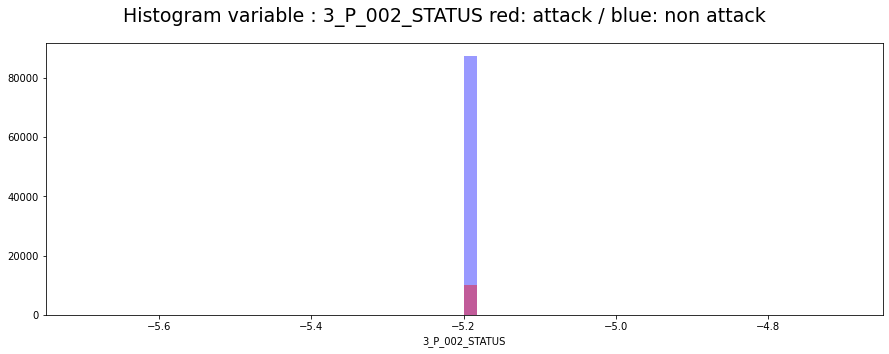

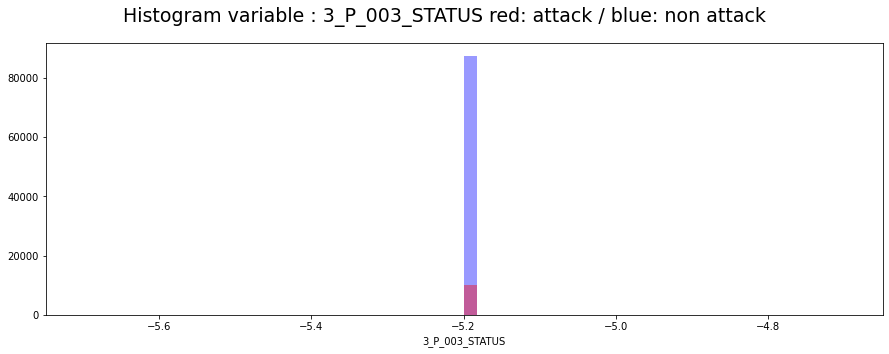

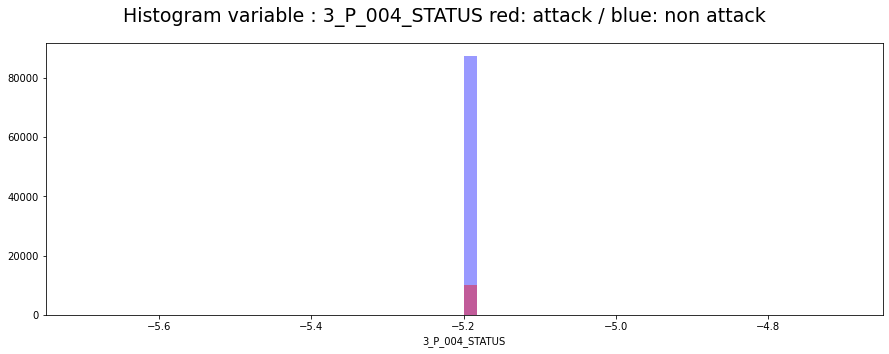

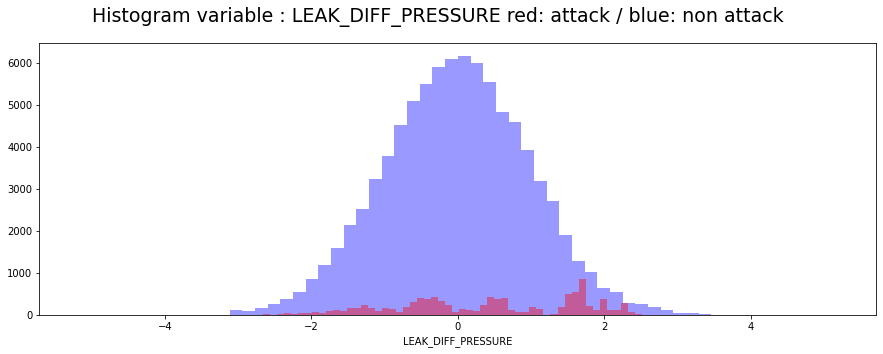

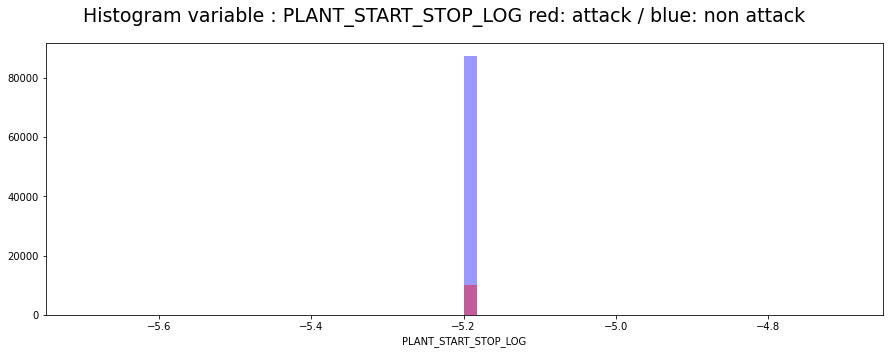

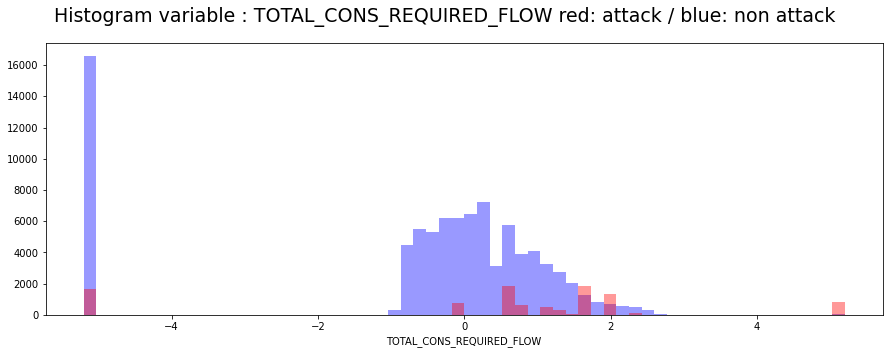

In [34]:
for varname in dfF.columns.values[3:-1]:
    

    plt.figure(figsize=(15,5))
    plt.suptitle('Histogram variable : ' + varname + ' red: attack / blue: non attack  ' ,fontsize=19)
    sns.distplot(dfF[dfF.label == 1  ].sample(frac=0.30)[varname],kde=False,bins=60,label='Normal',color='blue')
    sns.distplot(dfF[dfF.label == -1 ][varname],kde=False,bins=60,label='Normal',color='red')


    plt.show()

In [ ]:
#on observe que sur quelques variables les attaques peuvent etre séparées 

In [ ]:
#######################################
####################################### avec QuantileTransformer
######################################

In [ ]:
#on essaye directement les algos de outlier detection

In [30]:
dfSmaller =  dfF[dfF.label == 1].sample(frac=0.5)
data_train = dfSmaller.sample(frac=0.7)
data_test = dfSmaller.drop(data_train.index)
data_testAttack = dfF[dfF.label == -1]
len(dfSmaller)

#on doit encore réduire le dataset, sinon il passe pas dans les algos

145706

In [ ]:
#méthode pour calculer des résultats avec les algos de outlier detection

#on fit le modèle

#on prédit que des valeurs dont on sait quelles sont normales
# le modèle doit donc sortir que des  1 (non-attaque)

#on prédit que des valeurs dont on sait quelles sont des attaques
# le modèle doit donc sortir que des  -1 (attaque)




In [23]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=4 , novelty=True, contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    43702
-1     4912
dtype: int64


In [24]:
# cela semble etre un bon début

In [25]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8481
 1    1496
dtype: int64


In [18]:
dfSmaller =  dfF[dfF.label == 1].sample(frac=0.75)
data_train = dfSmaller.sample(frac=0.7)
data_test = dfSmaller.drop(data_train.index)
data_testAttack = dfF[dfF.label == -1]
len(dfSmaller)

#on augmente le nombre d'observations

218560

In [41]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=4 , novelty=True, contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    63504
-1     6110
dtype: int64


In [3]:
#score moyen
6110/(63504+6110)*100-100

-91.22302985031746

In [42]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8378
 1    1599
dtype: int64


In [2]:
1599/(8378+1599)*100-100

-83.97313821790118

In [25]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=17, n_jobs=4 , novelty=True, contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    50401
-1     4983
dtype: int64


In [5]:
4983/(50401+4983)*100-100

-91.00281669796331

In [26]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8507
 1    1470
dtype: int64


In [4]:
1470/(8507+1470)*100-100

-85.26611205773278

In [ ]:
#bon score

In [36]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=15, n_jobs=4 , novelty=True, contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    50577
-1     4807
dtype: int64


In [37]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8471
 1    1506
dtype: int64


In [38]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=14, n_jobs=4 , novelty=True, contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    50663
-1     4721
dtype: int64


In [39]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8459
 1    1518
dtype: int64


In [ ]:
#bon score

In [29]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=22, n_jobs=4 , novelty=True, contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    50178
-1     5206
dtype: int64


In [30]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8400
 1    1577
dtype: int64


In [43]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=4 , novelty=True, contamination='auto',metric='chebyshev').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    64090
-1     5524
dtype: int64


In [44]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    7532
 1    2445
dtype: int64


In [ ]:
#n_neighbors>25 ne sert à rien

In [19]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=18, n_jobs=4 , novelty=True, contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    42185
-1     4352
dtype: int64


In [20]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8315
 1    1662
dtype: int64


In [ ]:
# bon score

In [34]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=50, n_jobs=4 , novelty=True, contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    50029
-1     5355
dtype: int64


In [35]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    7293
 1    2684
dtype: int64


In [40]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=4 , novelty=True, contamination='auto',metric='euclidean').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




prédiction valeurs normales
 1    50201
-1     5183
dtype: int64


In [41]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8481
 1    1496
dtype: int64


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=4 , novelty=True, contamination='auto',metric='canberra').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




In [ ]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


In [ ]:
#trop lourd cette métric canberra

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=4 , novelty=True, contamination='auto',metric='braycurtis').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())




In [ ]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


In [ ]:
#trop lourd cette métric braycurtis

In [ ]:
### isolation forest

In [26]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest( contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())

prédiction valeurs normales
 1    43305
-1     5309
dtype: int64


In [27]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    5096
 1    4881
dtype: int64


In [ ]:
#la prédiciton d'une attque est 50/50, pas bon

In [38]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest( contamination='auto',n_estimators=150,bootstrap=True).fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())

prédiction valeurs normales
 1    43503
-1     5111
dtype: int64


In [ ]:
# 90%

In [39]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    5076
 1    4901
dtype: int64


In [ ]:
#46%

In [ ]:
#la prédiciton d'une attque est 50/50, pas bon  

In [ ]:
### EllipticEnvelope env

In [32]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope( contamination=0.0).fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())

/home/AI357/.local/lib/python3.6/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


prédiction valeurs normales
 1    35296
-1        1
dtype: int64


In [33]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
1    9977
dtype: int64


In [ ]:
# ne fonctionne pas du tout

In [50]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope( contamination=0.01).fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())

C:\ProgramData\Anaconda3\envs\IA 1\lib\site-packages\sklearn\covariance\robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


prédiction valeurs normales
 1    62866
-1      644
dtype: int64


In [51]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
 1    9862
-1     115
dtype: int64


In [ ]:
#très mauvais

In [ ]:
### OneClassSVM

In [36]:
dfSmaller =  dfF[dfF.label == 1].sample(frac=0.1)
data_train = dfSmaller.sample(frac=0.7)
data_test = dfSmaller.drop(data_train.index)
data_testAttack = dfF[dfF.label == -1]
len(dfSmaller)

48141

In [41]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM 


clf = OneClassSVM( kernel="rbf",gamma='auto',nu=0.75,verbose=True).fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())

[LibSVM]prédiction valeurs normales
-1    10581
 1     3555
dtype: int64


In [42]:
res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs Anormales
-1    8845
 1    1132
dtype: int64


In [ ]:
#très mauvais

In [ ]:
##########################################################################################
##########################################################################################

# classif

##########################################################################################
##########################################################################################

In [26]:
len(dfF[dfF.label == -1]) #nombre attaque

9977

In [27]:
len(dfF[dfF.label == 1]) #nombre non attaque

291412

In [28]:
################################################################################################################

In [29]:
# si pas de scaler avant
#from sklearn.preprocessing import QuantileTransformer
#scaler = QuantileTransformer(output_distribution = "normal")
#df_x = df.drop(['result'],axis=1)
#df[df.columns.values[:-1]] = scaler.fit_transform(df_x)

In [30]:

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn import ensemble

data_train = dfF.sample(frac=0.7)
data_test = dfF.drop(data_train.index)


Y_train = data_train['label'].values
X_train = data_train.drop(['Row', 'Date', 'Time','label'],axis=1).values




Y_test = data_test['label'].values
X_test = data_test.drop(['Row', 'Date', 'Time','label'],axis=1).values


print(print(pd.Series(Y_test).value_counts()))

 1    50872
-1      861
dtype: int64
None


0.9999613399570874
[0.99883856 0.99998034]


Text(0.5, 1.0, 'importance de la feature')

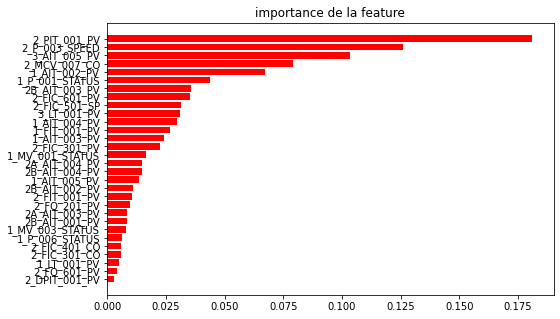

In [37]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))
importances = model.feature_importances_
indices = np.argsort(importances)[-30:]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)),importances[indices],color='r',align='center')
plt.yticks(range(len(indices)),dfF.drop(['Row', 'Date', 'Time','label'],axis=1).columns[indices]) 
plt.title("importance de la feature")

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_dct)

array([[  860,     1],
       [    1, 50871]])

In [39]:
print("accuracy score, f1, and precision")

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
print(accuracy_score(Y_test, y_dct))
print(f1_score(Y_test, y_dct))
print(precision_score(Y_test, y_dct))


accuracy score, f1, and precision
0.9999613399570874
0.9999803428211983
0.9999803428211983


In [34]:
from sklearn import tree
model = ensemble.RandomForestClassifier()
model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))

0.999942009935631
[0.99825683 0.99997051]


In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_dct)

array([[  859,     2],
       [    1, 50871]])

In [36]:
print("accuracy score, f1, and precision")

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
print(accuracy_score(Y_test, y_dct))
print(f1_score(Y_test, y_dct))
print(precision_score(Y_test, y_dct))


accuracy score, f1, and precision
0.999942009935631
0.9999705145215981
0.9999606864151908


In [32]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
model = HistGradientBoostingClassifier()
model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))

0.9938971997620569
[0.93958561 0.99678628]


In [29]:
from sklearn import tree
model = GradientBoostingClassifier()
model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))

0.9992573304237801
[0.95152603 0.9996258 ]


In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_dct)

array([[   795,     76],
       [     5, 108190]], dtype=int64)

In [29]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))

0.9927515477318293
[0.9280245 0.9961836]


In [30]:
from sklearn.ensemble import  ExtraTreesClassifier
modelerf =  ExtraTreesClassifier()
modelerf.fit(X_train,  Y_train)

y_dct = modelerf.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))




0.9925091982638965
[0.92427617 0.99605971]


In [31]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
print(accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))

0.9871554781995637
[0.86551326 0.99325567]


In [ ]:
###################################################################################################################
## cross val

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
model = HistGradientBoostingClassifier()
ss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
ss.get_n_splits(X_train, Y_train)
for train_index, test_index in ss.split(X_train, Y_train):
    trainx, testx = X_train[train_index], X_train[test_index]
    trainy, testy = Y_train[train_index], Y_train[test_index]
    model.fit(trainx,  trainy)
    y_dct = model.predict(testx)
    print(f1_score(testy, y_dct, average=None))
y_dct = model.predict(X_test)

print('final score : ',accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))

[0.99634523 0.99986793]
[0.99606631 0.99985776]
[0.99705015 0.99989332]
[0.99522472 0.99982728]
[0.99579596 0.99984759]
final score :  0.999836957629364
[0.99556049 0.99991695]


In [36]:
from sklearn.model_selection import StratifiedShuffleSplit
model =  ExtraTreesClassifier()
ss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
ss.get_n_splits(X_train, Y_train)
for train_index, test_index in ss.split(X_train, Y_train):
    trainx, testx = X_train[train_index], X_train[test_index]
    trainy, testy = Y_train[train_index], Y_train[test_index]
    model.fit(trainx,  trainy)
    y_dct = model.predict(testx)
    print(f1_score(testy, y_dct, average=None))
    
y_dct = model.predict(X_test)

print('final score : ',accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))

[0.99564546 0.99984252]
[0.99423915 0.99979172]
[0.99592525 0.99985268]
[0.99634523 0.99986793]
[0.9962084  0.99986284]
final score :  0.9998980985183524
[0.99722684 0.9999481 ]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)
ss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
ss.get_n_splits(X_train, Y_train)
for train_index, test_index in ss.split(X_train, Y_train):
    trainx, testx = X_train[train_index], X_train[test_index]
    trainy, testy = Y_train[train_index], Y_train[test_index]
    model.fit(trainx,  trainy)
    y_dct = model.predict(testx)
    print(f1_score(testy, y_dct, average=None))
    
y_dct = model.predict(X_test)

print('final score : ',accuracy_score(Y_test,   y_dct))
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_dct, average=None))

In [1]:

from sklearn import metrics #retenu pour publicaiton
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from statsmodels.tsa import stattools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import *

from sklearn.datasets import load_digits
from scipy.io import arff

from sklearn.feature_selection import SelectKBest, chi2


dfL = pd.read_csv('WADI_attackdataLABLE.csv',header=1) #contient NON-ATTACK ET ATTACK

dfL = pd.concat([dfL[dfL.label == 1].sample(frac=0.5),dfL[dfL.label == -1]],axis=0)

dfL.dropna(subset =['Time'], inplace=True)
dfL = dfL.fillna(0)


df = pd.read_csv("WADI_14days_new.csv") # contient seulement NON-ATTACK
#df = df[df.Row < 500000]
print(len(df))

df = df.sample(n=110000)


df = df.fillna(0) # on pourrait aussi remplacer par une valeur moyenne

## essaie 1

dfL.columns = np.append(df.columns.values,'label')

dtempolabel = pd.DataFrame( data = np.full(len(df),1) , columns = ['label']   )
dtempolabel.reset_index()
df.reset_index()


df = pd.DataFrame( data = df.values , columns = df.columns.values  )

dfF =  pd.concat([ pd.concat([df  , dtempolabel ],axis=1) , dfL ],axis=0)

df=None
dfL=None
##


784571


In [2]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(output_distribution = "normal")

dfF[dfF.columns.values[3:-1]] = scaler.fit_transform(dfF[dfF.columns.values[3:-1]])

In [3]:

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn import ensemble

data_train = dfF.sample(frac=0.7)
data_test = dfF.drop(data_train.index)


Y_train = data_train['label'].values
X_train = data_train.drop(['Row', 'Date', 'Time','label','PLANT_START_STOP_LOG'],axis=1).values




Y_test = data_test['label'].values
X_test = data_test.drop(['Row', 'Date', 'Time','label','PLANT_START_STOP_LOG'],axis=1).values


print(print(pd.Series(Y_test).value_counts()))
print(print(pd.Series(Y_train).value_counts()))


 1    34220
-1     1601
dtype: int64
None
 1    134096
-1      6876
dtype: int64
None


In [4]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model.fit(X_train,  Y_train)

y_dct = model.predict(X_test)
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print(accuracy_score(Y_test,   y_dct))
print(f1_score(Y_test, y_dct,average='macro'))
print(precision_score(Y_test, y_dct,average='macro')) 

0.999804583903297
0.9988568143921017
0.9984121712698119


In [5]:
y_dct = model.predict(X_train)
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print(accuracy_score(Y_train,   y_dct))
print(f1_score(Y_train, y_dct,average='macro'))
print(precision_score(Y_train, y_dct,average='macro')) 

0.9999148767131062
0.9995415175678092
0.9993349337973435


In [ ]:
######################################################################################################################

In [ ]:
###############################################################################################################*
######### tests quantile normal


# on fait des scores pour la publication 

In [1]:

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from statsmodels.tsa import stattools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import *

from sklearn.datasets import load_digits
from scipy.io import arff

from sklearn.feature_selection import SelectKBest, chi2


dfL = pd.read_csv('WADI_attackdataLABLE.csv',header=1) #contient NON-ATTACK ET ATTACK

dfL = pd.concat([dfL[dfL.label == 1].sample(frac=0.5),dfL[dfL.label == -1]],axis=0)

dfL.dropna(subset =['Time'], inplace=True)
dfL = dfL.fillna(0)


df = pd.read_csv("WADI_14days_new.csv") # contient seulement NON-ATTACK
#df = df[df.Row < 500000]
print(len(df))

df = df.sample(n=210000)


df = df.fillna(0) # on pourrait aussi remplacer par une valeur moyenne

## essaie 1

dfL.columns = np.append(df.columns.values,'label')

dtempolabel = pd.DataFrame( data = np.full(len(df),1) , columns = ['label']   )
dtempolabel.reset_index()
df.reset_index()


df = pd.DataFrame( data = df.values , columns = df.columns.values  )

dfF =  pd.concat([ pd.concat([df  , dtempolabel ],axis=1) , dfL ],axis=0)

df=None
dfL=None
##


784571


In [2]:

from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(output_distribution = "normal")

dfF[dfF.columns.values[3:-1]] = scaler.fit_transform(dfF[dfF.columns.values[3:-1]])



dfSmaller =  dfF[dfF.label == 1].sample(frac=0.5)
data_train = dfSmaller.sample(frac=0.7)
data_test = dfSmaller.drop(data_train.index)
data_testAttack = dfF[dfF.label == -1]
len(dfSmaller)


from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, n_jobs=4 , novelty=True, contamination='auto',metric='braycurtis').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales local outlier")
print(pd.Series(res).value_counts())

res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales local outlier")
print(pd.Series(res).value_counts())

from sklearn.ensemble import IsolationForest
clf = IsolationForest( contamination='auto').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales IsolationForest")
print(pd.Series(res).value_counts())

res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales IsolationForest")
print(pd.Series(res).value_counts())


prédiction valeurs normales local outlier
 1    31998
-1     3070
dtype: int64
prédiction valeurs Anormales local outlier
-1    8885
 1    1092
dtype: int64
prédiction valeurs normales IsolationForest
 1    31464
-1     3604
dtype: int64
prédiction valeurs Anormales IsolationForest
-1    5737
 1    4240
dtype: int64


In [3]:
 ((100-1092/(1092+8885)*100)+(100-3070/(3070+31998)*100))/2 # score pour lof

90.15020305799952

In [5]:
 ((100-4240/(5737+4240)*100)+(100-3604/(31464+3604)*100))/2 # score pour isolation forst

73.61253970707281

In [ ]:
############# score lof 

In [9]:
#accuracy
(31998+8885)/(8885+31998  +3070+1092)

0.9076035076035076

In [10]:
#precision score
(8885)/(8885+3070)

0.7432036804684232

In [11]:
#recall score
(8885)/(8885+1092)

0.8905482610003007

In [12]:
#f1
((((8885)/(8885+1092))*((8885)/(8885+3070)))/(((8885)/(8885+1092))+((8885)/(8885+3070))))*2

0.8102316250227976

In [ ]:
############# score isolation forest

In [4]:
#accuracy
(31464+5737)/(5737+31464+4240+3604)

0.8258630258630258

In [5]:
#precision score
(5737)/(5737+3604)

0.6141740712985762

In [7]:
#recall score
(5737)/(5737+4240)

0.5750225518692994

In [8]:
#f1
((((5737)/(5737+3604))*((5737)/(5737+4240)))/(((5737)/(5737+3604))+((5737)/(5737+4240))))*2

0.593953825447769

In [34]:
from sklearn.cluster import MiniBatchKMeans

cluster = MiniBatchKMeans(n_clusters=2, random_state=0)

cluster.fit(pd.concat([data_testAttack,data_train]).drop(['Row', 'Date', 'Time','label'],axis=1))

res = cluster.predict(data_test.sample(n=10000).drop(['Row', 'Date', 'Time','label'],axis=1).sample(n=10000))
print("prédiction valeurs normales")
print(pd.Series(res).value_counts())

res = cluster.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales")
print(pd.Series(res).value_counts())


prédiction valeurs normales
1    5309
0    4691
dtype: int64
prédiction valeurs Anormales
0    6618
1    3359
dtype: int64


In [ ]:
#foncitonne pas

In [ ]:
#########################################################################
# on essaye avec power scaler  // on essaye que les algos qui fonctionnent très bien sur les sclaer précédents
# power scaler


#on fait des scores pour la publication

In [1]:

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from statsmodels.tsa import stattools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import *

from sklearn.datasets import load_digits
from scipy.io import arff

from sklearn.feature_selection import SelectKBest, chi2


dfL = pd.read_csv('WADI_attackdataLABLE.csv',header=1) #contient NON-ATTACK ET ATTACK

dfL = pd.concat([dfL[dfL.label == 1].sample(frac=0.5),dfL[dfL.label == -1]],axis=0)

dfL.dropna(subset =['Time'], inplace=True)
dfL = dfL.fillna(0)


df = pd.read_csv("WADI_14days_new.csv") # contient seulement NON-ATTACK
#df = df[df.Row < 500000]
print(len(df))

df = df.sample(n=120000)


df = df.fillna(0) # on pourrait aussi remplacer par une valeur moyenne

## essaie 1

dfL.columns = np.append(df.columns.values,'label')

dtempolabel = pd.DataFrame( data = np.full(len(df),1) , columns = ['label']   )
dtempolabel.reset_index()
df.reset_index()


df = pd.DataFrame( data = df.values , columns = df.columns.values  )

dfF =  pd.concat([ pd.concat([df  , dtempolabel ],axis=1) , dfL ],axis=0)

df=None
dfL=None
##


784571


In [2]:
from sklearn.preprocessing import PowerTransformer # retenu pour pulication...
scaler = PowerTransformer()

dfF[dfF.columns.values[3:-1]] = scaler.fit_transform(dfF[dfF.columns.values[3:-1]])



dfSmaller =  dfF[dfF.label == 1].sample(frac=0.7)
data_train = dfSmaller.sample(frac=0.7)
data_test = dfSmaller.drop(data_train.index)
data_testAttack = dfF[dfF.label == -1]
len(dfSmaller)


from sklearn.neighbors import LocalOutlierFactor
print("debut fit")
clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1 , novelty=True, contamination='auto',metric='braycurtis').fit(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))

res = clf.predict(data_test.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs normales local outlier")
print(pd.Series(res).value_counts())

res = clf.predict(data_testAttack.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs Anormales local outlier")
print(pd.Series(res).value_counts())




/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


debut fit
prédiction valeurs normales local outlier
 1    28306
-1     2381
dtype: int64
prédiction valeurs Anormales local outlier
-1    8789
 1    1188
dtype: int64


In [4]:
 ((100-2381/(2381+28306)*100)+(100-1188/(1188+8789)*100))/2 # score pour lof

90.16681356006617

In [5]:
 2381/(28306+2381) # faux positifs
    

0.07758985889790465

In [6]:
#accuracy
(28306+8789)/(28306+2381+8876+1188)

0.9102844101985227

In [7]:
#precision score
(8789)/(8789+2381)

0.7868397493285586

In [8]:
#recall score
(8789)/(8789+1188)

0.8809261300992283

In [9]:
#f1
(((8789)/(8789+2381)*(8789)/(8789+1188))/((8789)/(8789+2381)+(8789)/(8789+1188)))*2

0.8312290159360667

In [ ]:
#pour le dataset de train :
#on ne fit que sur des données normales
#si on veut obtenir un score il faut prédire sur des anomalies également

In [3]:
res = clf.predict(data_train.drop(['Row', 'Date', 'Time','label'],axis=1))
print("prédiction valeurs train local outlier")
print(pd.Series(res).value_counts())


prédiction valeurs train local outlier
 1    92082
-1     6610
dtype: int64


In [ ]:
# on reprend les scores sur de dataset d'annomalies
#prédiction valeurs Anormales local outlier
-1    8789
 1    1188

In [ ]:
 ((100-2381/(2381+28306)*100)+(100-1188/(1188+8789)*100))/2 # score pour lof

In [10]:
6610/(92082+6610) # faux positifs

0.06697604669071455

In [11]:
(92082+8789)/(92082+6610+8789+1188) #accuracy

0.928240804645299

In [12]:
#precision score
(8789)/(8789+6610)

0.5707513474900967

In [13]:
#F1
(((8789)/(8789+6610)*(8789)/(8789+1188))/((8789)/(8789+6610)+(8789)/(8789+1188)))*2

0.6927017654476669